`PART B: Modeling:`

# **1. Importing Dependencies:**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install catboost

In [2]:
import os
import math
import joblib
import pickle
import catboost
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

'''import tensorflow
import tensorboard
from tensorflow.keras import models
import tensorflow.keras.backend as K
from sklearn.impute import SimpleImputer 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint'''

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
#Reference:https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
import pandas as pd
import numpy as np
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



# **2. Evaluation Matrics:**

#### **2.1 Root Mean Squared Error (RMSE):**
RMSE represents the standard deviation of the residuals. It gives an idea about how large the residuals are being dispersed. Interpretability of RMSE is relatively high as compared with MSE as it possesses same units as that of the datapoints. RSME is useful when the lower residual values are preferred.

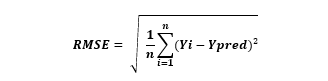

In [4]:
def compute_RMSE(y_true, y_pred):
  from sklearn.metrics import mean_squared_error
  RMSE = np.round(math.sqrt(mean_squared_error(y_true, y_pred)),2)
  return RMSE

RMSE might be the most appropriate evaluation matrics for this case study because RMSE has below advantages:
* The unit of RMSE is same as that of target variable, which makes it relatively more intrepretable in terms of measurement of units as compared to MSE.
* RSME gives more weight to greater errors than MAE.  It has more strict behaviour while pennalizing larger errors.
* As RMSE takes square of errors, it makes it more sensative to outliers in error distribution. 
* In this case study, after performing targer transformation (log-transformation), we can see that it follows a kind of normal distribution ***(Refer section 7.3)***. And many studies indicates that RSME is appropriate performance metrics for samples with normal distribution.


#### **2.2 Root Mean Squared Logarithmic Error (RMSLE):**

RMSLE is basically a modification of RMSE. As name suggest, errors are calculated on the logarithmic scale.When the actual and predicted values are same, the RMSLE will become undefined as the log of zero is undefined. To prevent this, the constant ‘1’ is added to both actual and predicted values to prevent. Unlike MSE, it doesn’t penalize large errors differently.

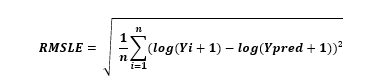

In [5]:
def compute_RMSLE(y_true, y_pred):
  from sklearn.metrics import mean_squared_log_error
  #Problem: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
  #Replace negative predicted values = 0 to avoid value errors.
  y_pred_ = np.where(y_pred <0 , 0, y_pred)  
  RMSLE = np.round(math.sqrt(mean_squared_log_error(y_true, y_pred_)),2)
  return RMSLE

RMSLE is usually used when both predicted and true values are huge numbers and  we dont want to pennalise huge residual errors. Below is the comparison between RMSE and RMSLE values. [Ref.](https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/)
* If both predicted and actual values are small: RMSE and RMSLE are same.
* If either predicted or the actual value is big: RMSE > RMSLE
* If both predicted and actual values are big: RMSE > RMSLE (RMSLE becomes almost negligible).

<br>RMSLE might also be appropriate evaluation matrics for this case study because RMSLE adress some of the problems faced when we use RMSE as a matrics. [Ref.](https://https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

* **Robustness:** RMSLE is more robust than RMSE. In the case of RMSE, if the data contains extreme outliers, the error term can explode to a very high value. In RMSLE since log term is used, it scale down the effect of outliers. RMSLE errors does not gets affected much by outliers. We have many outliers in our dataset. (***Refer section 8.4.2.*** )
* **Biased Penalty:** RMSLE value is high when predicted value is less than Actual value. On the other hand, RMSLE is low when Predicted value is more than the Actual value. This property can be helpful in this caase study as we are predicting the Energy consumptions how much energy any building would have consumed without any retrofit and users are gettng paid according to the difference between the energy consumed after retrofit and would have been consumed without any retrofit. 

#### **2.3	Coefficient of Variation of the RMSE CV(RMSE):**
Cofficient of variation(CV), is also known as relative standard drviation. It is a standardised measure of dispersion and often expressed as a pecentage. 
CV(RMSE) is a modified version of RMSE. RMSE is normalized by average of target variables. 


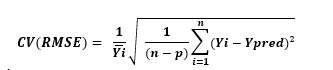

<br> Where in, 
<br>	`Y ̅i – Average of measured (target) values`
<br>`	N – Number of compared values`
<br>	`P – parameters = 1` 
<br>	`Ypred – predicted values by model`



In [6]:
def compute_RMSE_CV(y_true, y_pred):

  if not isinstance(y_true, np.ndarray):
    y_true = np.array(y_true)

  if not isinstance(y_pred, np.ndarray):
    y_pred = np.array(y_pred)

  sq_diff = list(np.square(y_true - y_pred))
  sum_sq_diff = sum(sq_diff)
  n = len(sq_diff)
  p = 1

  RMSE_CV = np.round((np.sqrt(sum_sq_diff / (n-p)))/ y_true.mean(),2)

  return RMSE_CV

#### **2.4	Manual Score Function in GridSearchCV:**

* Coefficient of variation explains the relative dispersion of data points in the data series around the mean.
* Lower the ration is better. As per ASHRAE Guideline 14, a CV(RMSE) of and below (+/-)25% indicates a good model fit with acceptable predictive capabilities

In [7]:
#Manual Score Function in GridSearchCV
score = make_scorer(compute_RMSE, greater_is_better=False)

# **3.Loading Train Data:**

#### **3.1 Without Scaling:**

In [8]:
data_cleaned = pd.read_feather("preprocessed_data_train.ftr")

Dropping Unwanted Features.

In [9]:
data_cleaned = data_cleaned.drop(['site_id','dew_temperature', 'Ea', 'Es', 'year' ], axis=1)

In [10]:
#As the timestamps are available, we can perform Time-Based Splitting.
data_cleaned = data_cleaned.sort_values(by='timestamp').reset_index(drop=True)

#Removing Timestamp other unwanted features.
data_cleaned = data_cleaned.drop(['meter_reading', 'meter_reading_corrected', 'timestamp', 'floor_count'], axis=1)

#Setting up target variable.
y = data_cleaned.meter_reading_transformed
X = data_cleaned.drop(['meter_reading_transformed'], axis=1)

#Splitting Data
X_train, X_cv, y_train, y_cv  = train_test_split(X, y, train_size=0.8, shuffle=False)

#### **3.2 With Scaling:**

In [ ]:
data_cleaned_lr = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train_scaled.ftr")

In [ ]:
data_cleaned_lr = data_cleaned_lr.drop(['site_id','dew_temperature', 'Ea', 'Es', 'year' ], axis=1)

In [ ]:
#As the timestamps are available, we can perform Time-Based Splitting.
data_cleaned_lr = data_cleaned_lr.sort_values(by='timestamp').reset_index(drop=True)

#Removing Timestamp other unwanted features.
data_cleaned_lr = data_cleaned_lr.drop(['meter_reading', 'meter_reading_corrected', 'timestamp', 'floor_count'], axis=1)

#Setting up target variable.
y_lr = data_cleaned_lr.meter_reading_transformed
X_lr = data_cleaned_lr.drop(['meter_reading_transformed'], axis=1)

#Splitting Data
X_train_lr, X_cv_lr, y_train_lr, y_cv_lr  = train_test_split(X_lr, y_lr, train_size=0.8, shuffle=False)

# **4. Regression Models:**

### **4.1 Base Model:**
 Using **Linear Regression** as a Base Model:<br>
 

In [ ]:
#Defining Model
base_model = LinearRegression(n_jobs=-1)

#Training the model (on scaled data)
base_model.fit(X_train_lr, y_train_lr)

#Predictions
y_cv_pred = base_model.predict(X_cv_lr)
y_train_pred = base_model.predict(X_train_lr)

#Evaluation

base_cv_RMSE = compute_RMSE(y_cv_lr, y_cv_pred)
base_train_RMSE = compute_RMSE(y_train_lr, y_train_pred)

base_CV_RMSLE = compute_RMSLE(y_cv_lr, y_cv_pred)
base_train_RMSLE = compute_RMSLE(y_train_lr, y_train_pred)

base_cv_RMSECV = compute_RMSE_CV(y_cv_lr, y_cv_pred)
base_train_RMSECV = compute_RMSE_CV(y_train_lr, y_train_pred)

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/base_model_Rev02.sav'
joblib.dump(base_model, filename)

#Report
print("--"*25)
print("For BASE Model the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(base_train_RMSLE, base_CV_RMSLE))
print("--"*25)
print("For BASE Model the RMSE values are \n    train RMSE = {0} \n    CV RMSE = {1}".format(base_train_RMSE, base_cv_RMSE))
print("--"*25)
print("For BASE Model the RMSLE(CV) values are \n    train RMSE(CV) = {0}  \n    CV RMSE(CV) = {1} ".format(base_train_RMSECV, base_cv_RMSECV))
print("--"*25)

--------------------------------------------------
For BASE Model the RMSLE values are 
    train RMSLE = 0.32 
    CV RMSLE = 0.34
--------------------------------------------------
For BASE Model the RMSE values are 
    train RMSE = 1.44 
    CV RMSE = 1.48
--------------------------------------------------
For BASE Model the RMSLE(CV) values are 
    train RMSE(CV) = 0.32  
    CV RMSE(CV) = 0.33 
--------------------------------------------------


### **4.2 Decision Tree Regressor**

**Hyperparameter Tuning:**<br>
Here we are using custom Scoring Function / Evaluation Metrics. i.e. 
* RMSLE
* RMSE
* RMSE-CV
<br>Let's pass that in GridSearchCV. 
<br>***Reference***:*https://stackoverflow.com/questions/32401493/how-to-create-customize-your-own-scorer-function-in-scikit-learn*

In [ ]:
%time
#GridSearchCV parameters
dr_reg = DecisionTreeRegressor()
hyper_parameters = {'max_depth':[27,50,100],
                   'min_samples_split':[10,100,500]}
folds = KFold(n_splits=3, shuffle=False, random_state=None)

dr_reg_cv = GridSearchCV(estimator=dr_reg,
                        param_grid= hyper_parameters,
                        scoring=score,
                        cv=folds,
                        return_train_score=True,
                        n_jobs =15,
                        verbose=4)

#Training the model
dr_reg_cv.fit(X_train[:2000000], y_train[:2000000])

#Saving Results
dr_reg_cv_df = pd.DataFrame(dr_reg_cv.cv_results_)

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/dr_reg_cv_Rev02.pkl'
joblib.dump(dr_reg_cv, filename)

#saving the results into df
cv_results = pd.DataFrame(dr_reg_cv.cv_results_)

#Results
print("The best parameters are : {0}".format(dr_reg_cv.best_params_))



CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 9.3 µs
Fitting 3 folds for each of 9 candidates, totalling 27 fits
The best parameters are : {'max_depth': 27, 'min_samples_split': 100}


**Decision Tree with Best Parameters:**

In [ ]:
print("Best Parameters are : {}".format(dr_reg_cv.best_params_))
print("--"*25)

dt_reg_best = dr_reg_cv.best_estimator_
dt_reg_best.fit(X_train, y_train)

y_train_pred = dt_reg_best.predict(X_train)
y_cv_pred = dt_reg_best.predict(X_cv)


# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/dt_reg_best_Rev02.sav'
joblib.dump(dt_reg_best, filename)

Best Parameters are : {'max_depth': 27, 'min_samples_split': 100}
--------------------------------------------------


['/content/drive/MyDrive/Case Study 01/Data/dt_reg_best_Rev02.sav']

In [ ]:
#Evaluation
dt_reg_cv_RMSLE = compute_RMSLE(y_cv, y_cv_pred)
dt_reg_train_RMSLE = compute_RMSLE(y_train, y_train_pred)

dt_reg_cv_RMSE = compute_RMSE(y_cv, y_cv_pred)
dt_reg_train_RMSE = compute_RMSE(y_train, y_train_pred)

dt_reg_cv_RMSECV = compute_RMSE_CV(y_cv, y_cv_pred)
dt_reg_train_RMSECV = compute_RMSE_CV(y_train, y_train_pred)

#Report
print("1.For Decision Tree Regression Model the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(dt_reg_train_RMSLE, dt_reg_cv_RMSLE))
print("--"*25)
print("2.For Decision Tree Regression Model the RMSE values are \n    train RMSE = {0} \n    CV RMSE = {1}".format(dt_reg_train_RMSE, dt_reg_cv_RMSE))
print("--"*25)
print("3.For Decision Tree Regression Model the RMSLE(CV) values are \n    train RMSE(CV) = {0}  \n    CV RMSE(CV) = {1} ".format(dt_reg_train_RMSECV, dt_reg_cv_RMSECV))
print("--"*25)


1.For Decision Tree Regression Model the RMSLE values are 
    train RMSLE = 0.08 
    CV RMSLE = 0.17
--------------------------------------------------
2.For Decision Tree Regression Model the RMSE values are 
    train RMSE = 0.32 
    CV RMSE = 0.68
--------------------------------------------------
3.For Decision Tree Regression Model the RMSLE(CV) values are 
    train RMSE(CV) = 0.07  
    CV RMSE(CV) = 0.15 
--------------------------------------------------


### **4.3 Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Defining Model
RF_reg = RandomForestRegressor(n_estimators=250, min_samples_split=50, max_features=0.3, 
                               max_depth=15, n_jobs=50, bootstrap=True, verbose=25)

#Training the model (on scaled data)
#RF_reg.fit(X_train, y_train)
RF_reg.fit(X_train[:], y_train[:])

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/RF_reg_depth15_Rev02.sav'
joblib.dump(RF_reg, filename)

[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.


building tree 1 of 250building tree 2 of 250

building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250building tree 35 of 250

building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
b

[Parallel(n_jobs=50)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=50)]: Done   2 tasks      | elapsed:  2.1min


building tree 52 of 250


[Parallel(n_jobs=50)]: Done   3 tasks      | elapsed:  2.1min


building tree 53 of 250
building tree 54 of 250


[Parallel(n_jobs=50)]: Done   4 tasks      | elapsed:  2.1min


building tree 55 of 250


[Parallel(n_jobs=50)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=50)]: Done   6 tasks      | elapsed:  2.2min


building tree 56 of 250


[Parallel(n_jobs=50)]: Done   7 tasks      | elapsed:  2.2min


building tree 57 of 250


[Parallel(n_jobs=50)]: Done   8 tasks      | elapsed:  2.2min


building tree 58 of 250
building tree 59 of 250
building tree 60 of 250


[Parallel(n_jobs=50)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=50)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=50)]: Done  11 tasks      | elapsed:  2.2min


building tree 61 of 250
building tree 62 of 250
building tree 63 of 250


[Parallel(n_jobs=50)]: Done  12 tasks      | elapsed:  2.3min
[Parallel(n_jobs=50)]: Done  13 tasks      | elapsed:  2.3min


building tree 64 of 250


[Parallel(n_jobs=50)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=50)]: Done  15 tasks      | elapsed:  2.3min


building tree 65 of 250


[Parallel(n_jobs=50)]: Done  16 tasks      | elapsed:  2.3min


building tree 66 of 250


[Parallel(n_jobs=50)]: Done  17 tasks      | elapsed:  2.3min


building tree 67 of 250
building tree 68 of 250
building tree 69 of 250


[Parallel(n_jobs=50)]: Done  18 tasks      | elapsed:  2.4min
[Parallel(n_jobs=50)]: Done  19 tasks      | elapsed:  2.4min


building tree 70 of 250


[Parallel(n_jobs=50)]: Done  20 tasks      | elapsed:  2.4min
[Parallel(n_jobs=50)]: Done  21 tasks      | elapsed:  2.4min


building tree 71 of 250


[Parallel(n_jobs=50)]: Done  22 tasks      | elapsed:  2.4min


building tree 72 of 250
building tree 73 of 250


[Parallel(n_jobs=50)]: Done  23 tasks      | elapsed:  2.4min


building tree 74 of 250
building tree 75 of 250


[Parallel(n_jobs=50)]: Done  24 tasks      | elapsed:  2.4min
[Parallel(n_jobs=50)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=50)]: Done  26 tasks      | elapsed:  2.4min


building tree 76 of 250


[Parallel(n_jobs=50)]: Done  27 tasks      | elapsed:  2.4min
[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:  2.4min


building tree 77 of 250
building tree 78 of 250
building tree 79 of 250


[Parallel(n_jobs=50)]: Done  29 tasks      | elapsed:  2.4min


building tree 80 of 250


[Parallel(n_jobs=50)]: Done  30 tasks      | elapsed:  2.4min
[Parallel(n_jobs=50)]: Done  31 tasks      | elapsed:  2.5min


building tree 81 of 250


[Parallel(n_jobs=50)]: Done  32 tasks      | elapsed:  2.5min
[Parallel(n_jobs=50)]: Done  33 tasks      | elapsed:  2.5min


building tree 82 of 250
building tree 83 of 250
building tree 84 of 250


[Parallel(n_jobs=50)]: Done  34 tasks      | elapsed:  2.5min


building tree 85 of 250
building tree 86 of 250
building tree 87 of 250


[Parallel(n_jobs=50)]: Done  35 tasks      | elapsed:  2.5min
[Parallel(n_jobs=50)]: Done  36 tasks      | elapsed:  2.5min
[Parallel(n_jobs=50)]: Done  37 tasks      | elapsed:  2.5min


building tree 88 of 250


[Parallel(n_jobs=50)]: Done  38 tasks      | elapsed:  2.5min
[Parallel(n_jobs=50)]: Done  39 tasks      | elapsed:  2.5min


building tree 89 of 250
building tree 90 of 250


[Parallel(n_jobs=50)]: Done  40 tasks      | elapsed:  2.5min
[Parallel(n_jobs=50)]: Done  41 tasks      | elapsed:  2.5min


building tree 91 of 250
building tree 92 of 250


[Parallel(n_jobs=50)]: Done  42 tasks      | elapsed:  2.6min


building tree 93 of 250
building tree 94 of 250


[Parallel(n_jobs=50)]: Done  43 tasks      | elapsed:  2.6min
[Parallel(n_jobs=50)]: Done  44 tasks      | elapsed:  2.6min
[Parallel(n_jobs=50)]: Done  45 tasks      | elapsed:  2.6min


building tree 95 of 250
building tree 96 of 250building tree 97 of 250



[Parallel(n_jobs=50)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=50)]: Done  47 tasks      | elapsed:  2.6min
[Parallel(n_jobs=50)]: Done  48 tasks      | elapsed:  2.7min


building tree 98 of 250


[Parallel(n_jobs=50)]: Done  49 tasks      | elapsed:  2.7min


building tree 99 of 250


[Parallel(n_jobs=50)]: Done  50 tasks      | elapsed:  3.0min


building tree 100 of 250


[Parallel(n_jobs=50)]: Done  51 tasks      | elapsed:  4.2min


building tree 101 of 250


[Parallel(n_jobs=50)]: Done  52 tasks      | elapsed:  4.3min


building tree 102 of 250
building tree 103 of 250


[Parallel(n_jobs=50)]: Done  53 tasks      | elapsed:  4.3min
[Parallel(n_jobs=50)]: Done  54 tasks      | elapsed:  4.4min
[Parallel(n_jobs=50)]: Done  55 tasks      | elapsed:  4.4min


building tree 104 of 250
building tree 105 of 250
building tree 106 of 250


[Parallel(n_jobs=50)]: Done  56 tasks      | elapsed:  4.4min
[Parallel(n_jobs=50)]: Done  57 tasks      | elapsed:  4.5min
[Parallel(n_jobs=50)]: Done  58 tasks      | elapsed:  4.5min


building tree 107 of 250
building tree 108 of 250


[Parallel(n_jobs=50)]: Done  59 tasks      | elapsed:  4.5min


building tree 109 of 250


[Parallel(n_jobs=50)]: Done  60 tasks      | elapsed:  4.5min


building tree 110 of 250


[Parallel(n_jobs=50)]: Done  61 tasks      | elapsed:  4.5min


building tree 111 of 250


[Parallel(n_jobs=50)]: Done  62 tasks      | elapsed:  4.6min


building tree 112 of 250
building tree 113 of 250


[Parallel(n_jobs=50)]: Done  63 tasks      | elapsed:  4.6min
[Parallel(n_jobs=50)]: Done  64 tasks      | elapsed:  4.6min


building tree 114 of 250


[Parallel(n_jobs=50)]: Done  65 tasks      | elapsed:  4.6min


building tree 115 of 250
building tree 116 of 250


[Parallel(n_jobs=50)]: Done  66 tasks      | elapsed:  4.6min


building tree 117 of 250building tree 118 of 250



[Parallel(n_jobs=50)]: Done  67 tasks      | elapsed:  4.6min
[Parallel(n_jobs=50)]: Done  68 tasks      | elapsed:  4.6min


building tree 119 of 250


[Parallel(n_jobs=50)]: Done  69 tasks      | elapsed:  4.6min
[Parallel(n_jobs=50)]: Done  70 tasks      | elapsed:  4.7min


building tree 120 of 250
building tree 121 of 250
building tree 122 of 250


[Parallel(n_jobs=50)]: Done  71 tasks      | elapsed:  4.7min
[Parallel(n_jobs=50)]: Done  72 tasks      | elapsed:  4.7min
[Parallel(n_jobs=50)]: Done  73 tasks      | elapsed:  4.8min


building tree 123 of 250


[Parallel(n_jobs=50)]: Done  74 tasks      | elapsed:  4.8min


building tree 124 of 250


[Parallel(n_jobs=50)]: Done  75 tasks      | elapsed:  4.8min


building tree 125 of 250


[Parallel(n_jobs=50)]: Done  76 tasks      | elapsed:  4.8min


building tree 126 of 250


[Parallel(n_jobs=50)]: Done  77 tasks      | elapsed:  4.8min


building tree 127 of 250


[Parallel(n_jobs=50)]: Done  78 tasks      | elapsed:  4.8min
[Parallel(n_jobs=50)]: Done  79 tasks      | elapsed:  4.8min


building tree 128 of 250
building tree 129 of 250


[Parallel(n_jobs=50)]: Done  80 tasks      | elapsed:  4.8min


building tree 130 of 250


[Parallel(n_jobs=50)]: Done  81 tasks      | elapsed:  4.9min


building tree 131 of 250
building tree 132 of 250
building tree 133 of 250


[Parallel(n_jobs=50)]: Done  82 tasks      | elapsed:  4.9min
[Parallel(n_jobs=50)]: Done  83 tasks      | elapsed:  4.9min
[Parallel(n_jobs=50)]: Done  84 tasks      | elapsed:  4.9min


building tree 134 of 250
building tree 135 of 250


[Parallel(n_jobs=50)]: Done  85 tasks      | elapsed:  4.9min
[Parallel(n_jobs=50)]: Done  86 tasks      | elapsed:  4.9min


building tree 136 of 250


[Parallel(n_jobs=50)]: Done  87 tasks      | elapsed:  4.9min


building tree 137 of 250


[Parallel(n_jobs=50)]: Done  88 tasks      | elapsed:  5.0min
[Parallel(n_jobs=50)]: Done  89 tasks      | elapsed:  5.0min
[Parallel(n_jobs=50)]: Done  90 tasks      | elapsed:  5.0min


building tree 138 of 250
building tree 139 of 250
building tree 140 of 250


[Parallel(n_jobs=50)]: Done  91 tasks      | elapsed:  5.0min


building tree 141 of 250
building tree 142 of 250


[Parallel(n_jobs=50)]: Done  92 tasks      | elapsed:  5.0min


building tree 143 of 250


[Parallel(n_jobs=50)]: Done  93 tasks      | elapsed:  5.0min
[Parallel(n_jobs=50)]: Done  94 tasks      | elapsed:  5.0min


building tree 144 of 250
building tree 145 of 250


[Parallel(n_jobs=50)]: Done  95 tasks      | elapsed:  5.0min


building tree 146 of 250


[Parallel(n_jobs=50)]: Done  96 tasks      | elapsed:  5.0min


building tree 147 of 250


[Parallel(n_jobs=50)]: Done  97 tasks      | elapsed:  5.0min


building tree 148 of 250


[Parallel(n_jobs=50)]: Done  98 tasks      | elapsed:  5.2min
[Parallel(n_jobs=50)]: Done  99 tasks      | elapsed:  5.2min


building tree 149 of 250


[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:  5.3min


building tree 150 of 250


[Parallel(n_jobs=50)]: Done 101 tasks      | elapsed:  6.4min


building tree 151 of 250


[Parallel(n_jobs=50)]: Done 102 tasks      | elapsed:  6.6min


building tree 152 of 250


[Parallel(n_jobs=50)]: Done 103 tasks      | elapsed:  6.7min


building tree 153 of 250


[Parallel(n_jobs=50)]: Done 104 tasks      | elapsed:  6.7min


building tree 154 of 250


[Parallel(n_jobs=50)]: Done 105 tasks      | elapsed:  6.7min
[Parallel(n_jobs=50)]: Done 106 tasks      | elapsed:  6.7min


building tree 155 of 250
building tree 156 of 250


[Parallel(n_jobs=50)]: Done 107 tasks      | elapsed:  6.8min


building tree 157 of 250


[Parallel(n_jobs=50)]: Done 108 tasks      | elapsed:  6.8min


building tree 158 of 250


[Parallel(n_jobs=50)]: Done 109 tasks      | elapsed:  6.9min


building tree 159 of 250


[Parallel(n_jobs=50)]: Done 110 tasks      | elapsed:  6.9min


building tree 160 of 250


[Parallel(n_jobs=50)]: Done 111 tasks      | elapsed:  6.9min


building tree 161 of 250


[Parallel(n_jobs=50)]: Done 112 tasks      | elapsed:  6.9min


building tree 162 of 250
building tree 163 of 250


[Parallel(n_jobs=50)]: Done 113 tasks      | elapsed:  6.9min
[Parallel(n_jobs=50)]: Done 114 tasks      | elapsed:  7.0min


building tree 164 of 250


[Parallel(n_jobs=50)]: Done 115 tasks      | elapsed:  7.0min


building tree 165 of 250


[Parallel(n_jobs=50)]: Done 116 tasks      | elapsed:  7.0min


building tree 166 of 250


[Parallel(n_jobs=50)]: Done 117 tasks      | elapsed:  7.0min


building tree 167 of 250


[Parallel(n_jobs=50)]: Done 118 tasks      | elapsed:  7.0min


building tree 168 of 250
building tree 169 of 250
building tree 170 of 250


[Parallel(n_jobs=50)]: Done 119 tasks      | elapsed:  7.0min
[Parallel(n_jobs=50)]: Done 120 tasks      | elapsed:  7.0min
[Parallel(n_jobs=50)]: Done 121 tasks      | elapsed:  7.0min


building tree 171 of 250


[Parallel(n_jobs=50)]: Done 122 tasks      | elapsed:  7.1min


building tree 172 of 250


[Parallel(n_jobs=50)]: Done 123 tasks      | elapsed:  7.1min


building tree 173 of 250


[Parallel(n_jobs=50)]: Done 124 tasks      | elapsed:  7.1min


building tree 174 of 250


[Parallel(n_jobs=50)]: Done 125 tasks      | elapsed:  7.1min


building tree 175 of 250
building tree 176 of 250


[Parallel(n_jobs=50)]: Done 126 tasks      | elapsed:  7.2min
[Parallel(n_jobs=50)]: Done 127 tasks      | elapsed:  7.2min
[Parallel(n_jobs=50)]: Done 128 tasks      | elapsed:  7.2min
[Parallel(n_jobs=50)]: Done 129 tasks      | elapsed:  7.2min


building tree 177 of 250
building tree 178 of 250
building tree 179 of 250


[Parallel(n_jobs=50)]: Done 130 tasks      | elapsed:  7.2min
[Parallel(n_jobs=50)]: Done 131 tasks      | elapsed:  7.2min


building tree 180 of 250building tree 181 of 250



[Parallel(n_jobs=50)]: Done 132 tasks      | elapsed:  7.3min


building tree 182 of 250


[Parallel(n_jobs=50)]: Done 133 tasks      | elapsed:  7.3min


building tree 183 of 250


[Parallel(n_jobs=50)]: Done 134 tasks      | elapsed:  7.3min


building tree 184 of 250


[Parallel(n_jobs=50)]: Done 135 tasks      | elapsed:  7.4min
[Parallel(n_jobs=50)]: Done 136 tasks      | elapsed:  7.4min


building tree 185 of 250
building tree 186 of 250


[Parallel(n_jobs=50)]: Done 137 tasks      | elapsed:  7.4min


building tree 187 of 250


[Parallel(n_jobs=50)]: Done 138 tasks      | elapsed:  7.4min
[Parallel(n_jobs=50)]: Done 139 tasks      | elapsed:  7.4min


building tree 188 of 250
building tree 189 of 250


[Parallel(n_jobs=50)]: Done 140 tasks      | elapsed:  7.4min


building tree 190 of 250


[Parallel(n_jobs=50)]: Done 141 tasks      | elapsed:  7.5min
[Parallel(n_jobs=50)]: Done 142 tasks      | elapsed:  7.5min


building tree 191 of 250
building tree 192 of 250


[Parallel(n_jobs=50)]: Done 143 tasks      | elapsed:  7.5min


building tree 193 of 250
building tree 194 of 250


[Parallel(n_jobs=50)]: Done 144 tasks      | elapsed:  7.5min
[Parallel(n_jobs=50)]: Done 145 tasks      | elapsed:  7.5min


building tree 195 of 250


[Parallel(n_jobs=50)]: Done 146 tasks      | elapsed:  7.5min


building tree 196 of 250


[Parallel(n_jobs=50)]: Done 147 tasks      | elapsed:  7.6min


building tree 197 of 250


[Parallel(n_jobs=50)]: Done 148 tasks      | elapsed:  7.6min


building tree 198 of 250


[Parallel(n_jobs=50)]: Done 149 tasks      | elapsed:  7.6min
[Parallel(n_jobs=50)]: Done 150 tasks      | elapsed:  7.6min


building tree 199 of 250
building tree 200 of 250


[Parallel(n_jobs=50)]: Done 151 tasks      | elapsed:  8.6min


building tree 201 of 250
building tree 202 of 250
building tree 203 of 250
building tree 204 of 250
building tree 205 of 250
building tree 206 of 250
building tree 207 of 250
building tree 208 of 250
building tree 209 of 250
building tree 210 of 250
building tree 211 of 250
building tree 212 of 250
building tree 213 of 250


[Parallel(n_jobs=50)]: Done 162 out of 250 | elapsed:  9.2min remaining:  5.0min


building tree 214 of 250
building tree 215 of 250
building tree 216 of 250
building tree 217 of 250
building tree 218 of 250
building tree 219 of 250
building tree 220 of 250
building tree 221 of 250
building tree 222 of 250
building tree 223 of 250


[Parallel(n_jobs=50)]: Done 173 out of 250 | elapsed:  9.4min remaining:  4.2min


building tree 224 of 250
building tree 225 of 250
building tree 226 of 250
building tree 227 of 250building tree 228 of 250

building tree 229 of 250
building tree 230 of 250
building tree 231 of 250
building tree 232 of 250
building tree 233 of 250


[Parallel(n_jobs=50)]: Done 184 out of 250 | elapsed:  9.7min remaining:  3.5min


building tree 234 of 250
building tree 235 of 250
building tree 236 of 250
building tree 237 of 250
building tree 238 of 250
building tree 239 of 250
building tree 240 of 250
building tree 241 of 250
building tree 242 of 250
building tree 243 of 250
building tree 244 of 250


[Parallel(n_jobs=50)]: Done 195 out of 250 | elapsed: 10.0min remaining:  2.8min


building tree 245 of 250
building tree 246 of 250
building tree 247 of 250
building tree 248 of 250
building tree 249 of 250
building tree 250 of 250


[Parallel(n_jobs=50)]: Done 206 out of 250 | elapsed: 11.3min remaining:  2.4min
[Parallel(n_jobs=50)]: Done 217 out of 250 | elapsed: 11.6min remaining:  1.8min
[Parallel(n_jobs=50)]: Done 228 out of 250 | elapsed: 11.7min remaining:  1.1min
[Parallel(n_jobs=50)]: Done 239 out of 250 | elapsed: 11.8min remaining:   32.5s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed: 12.0min finished


['/content/drive/MyDrive/Case Study 01/Data/RF_reg_depth15_Rev02.sav']

In [ ]:
# load the model from disk
RF_reg = joblib.load('/content/drive/MyDrive/Case Study 01/Data/RF_reg_depth15_Rev02.sav')

#Predictions
y_cv_pred = RF_reg.predict(X_cv)
y_train_pred = RF_reg.predict(X_train)


#Evaluation
RF_reg_cv_RMSLE = compute_RMSLE(y_cv[:], y_cv_pred)
RF_reg_train_RMSLE = compute_RMSLE(y_train[:], y_train_pred)

RF_reg_cv_RMSE = compute_RMSE(y_cv[:], y_cv_pred)
RF_reg_train_RMSE = compute_RMSE(y_train[:], y_train_pred)

RF_reg_cv_RMSE_CV = compute_RMSE_CV(y_cv[:], y_cv_pred)
RF_reg_train_RMSE_CV = compute_RMSE_CV(y_train[:], y_train_pred)



In [ ]:
#Report
print("--"*25)
print("1.For Random Forest the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(RF_reg_train_RMSLE, RF_reg_cv_RMSLE))
print("--"*25)
print("2.For Random Forest the RMSE values are \n    train RMSE = {0} \n    CV RMSLE = {1}".format(RF_reg_train_RMSE, RF_reg_cv_RMSE))
print("--"*25)
print("3.For Random Forest Regression Model the RMSLE(CV) values are \n    train RMSE(CV) = {0}  \n    CV RMSE(CV) = {1} ".format(RF_reg_train_RMSE_CV, RF_reg_cv_RMSE_CV))
print("--"*25)



--------------------------------------------------
1.For Random Forest the RMSLE values are 
    train RMSLE = 0.17 
    CV RMSLE = 0.2
--------------------------------------------------
2.For Random Forest the RMSE values are 
    train RMSE = 0.65 
    CV RMSLE = 0.76
--------------------------------------------------
3.For Random Forest Regression Model the RMSLE(CV) values are 
    train RMSE(CV) = 0.14  
    CV RMSE(CV) = 0.17 
--------------------------------------------------


### **4.4 LGBM Regressor**

##### **4.4.1 Model 1:**

In [11]:
import lightgbm as lgb

In [12]:
#Reference: https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

from lightgbm import LGBMRegressor
LGBM_reg = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='rmse', n_estimators=2100)

LGBM_reg.fit(X_train, y_train)

# save the model to disk
filename = 'LGBM_reg_Rev02_Aug15.sav'
joblib.dump(LGBM_reg, filename)

['LGBM_reg_Rev02_Aug15.sav']

In [ ]:
# load the model from disk
LGBM_reg = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_Rev02.sav')

#Predictions
y_cv_pred = LGBM_reg.predict(X_cv)
y_train_pred = LGBM_reg.predict(X_train)

In [ ]:
#Evaluation
LGBM_reg_cv_RMSLE = compute_RMSLE(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSLE = compute_RMSLE(y_train[:], y_train_pred)

LGBM_reg_cv_RMSE = compute_RMSE(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSE = compute_RMSE(y_train[:], y_train_pred)

LGBM_reg_cv_RMSECV = compute_RMSE_CV(y_cv, y_cv_pred)
LGBM_reg_train_RMSECV = compute_RMSE_CV(y_train, y_train_pred)

#Report
print("1.For LGBM_reg the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(LGBM_reg_train_RMSLE, LGBM_reg_cv_RMSLE))
print("--"*25)
print("2.For LGBM_reg the RMSE values are \n    train RMSE = {0} \n    CV RMSLE = {1}".format(LGBM_reg_train_RMSE, LGBM_reg_cv_RMSE))
print("--"*25)
print("3.For LGBM_reg the RMSLE(CV) values are \n    train RMSE(CV) = {0}  \n    CV RMSE(CV) = {1} ".format(LGBM_reg_train_RMSECV, LGBM_reg_cv_RMSECV))
print("--"*25)

##### **4.4.2 Hyperparameter Tuning**

In [ ]:
#GridSearchCV parameters
from lightgbm import LGBMRegressor
LGBM_reg = LGBMRegressor(subsample=0.3, colsample_bytree=0.3, subsample_freq=10, objective='rmse', n_jobd=50)
#LGBM_reg = LGBMRegressor()

hyper_parameters = {'boosting_type':['gbdt'],
                    'n_estimators':[500,1500,2000,2500],
                    'min_child_samples':[20, 31, 50, 100]}
folds = KFold(n_splits=3, shuffle=True, random_state=50)

LGBM_reg_cv = GridSearchCV(estimator=LGBM_reg,
                        param_grid= hyper_parameters,
                        scoring=score,
                        cv=folds,
                        return_train_score=True,
                        n_jobs =1,
                        verbose=5)

#Training the model
LGBM_reg_cv.fit(X_train, y_train)

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_cv_Rev02.pkl'
joblib.dump(LGBM_reg_cv, filename)

#saving the results into df
LGBM_reg_cv_cv_results = pd.DataFrame(LGBM_reg_cv.cv_results_)
LGBM_reg_cv_cv_results.to_csv('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_cv_results_Rev02.csv')


#Results
print("The best parameters are : {0}".format(LGBM_reg_cv.best_params_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END boosting_type=gbdt, min_child_samples=20, n_estimators=500;, score=(train=-0.750, test=-0.750) total time=  55.9s
[CV 2/3] END boosting_type=gbdt, min_child_samples=20, n_estimators=500;, score=(train=-0.750, test=-0.750) total time=  53.6s
[CV 3/3] END boosting_type=gbdt, min_child_samples=20, n_estimators=500;, score=(train=-0.750, test=-0.750) total time=  52.3s
[CV 1/3] END boosting_type=gbdt, min_child_samples=20, n_estimators=1500;, score=(train=-0.620, test=-0.620) total time= 2.3min
[CV 2/3] END boosting_type=gbdt, min_child_samples=20, n_estimators=1500;, score=(train=-0.620, test=-0.620) total time= 2.3min
[CV 3/3] END boosting_type=gbdt, min_child_samples=20, n_estimators=1500;, score=(train=-0.620, test=-0.620) total time= 2.4min
[CV 1/3] END boosting_type=gbdt, min_child_samples=20, n_estimators=2000;, score=(train=-0.580, test=-0.580) total time= 3.2min
[CV 2/3] END boosting_type=gbdt, min_child_sam

**Training Model with Best Parameters**

In [ ]:
print("Best Parameters are : {}".format(LGBM_reg_cv.best_params_))
print("--"*25)

LGBM_reg_best = LGBM_reg_cv.best_estimator_
LGBM_reg_best.fit(X_train, y_train)

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_best_Rev02.sav'
joblib.dump(LGBM_reg_best, filename)



Best Parameters are : {'boosting_type': 'gbdt', 'min_child_samples': 20, 'n_estimators': 2500}
--------------------------------------------------


['/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_best_Rev02.sav']

In [ ]:
# load the model from disk
LGBM_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_best_Rev02.sav')

y_train_pred = LGBM_reg_best.predict(X_train[:])
y_cv_pred = LGBM_reg_best.predict(X_cv[:])

#Evaluation
LGBM_reg_cv_RMSLE = compute_RMSLE(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSLE = compute_RMSLE(y_train[:], y_train_pred)

LGBM_reg_cv_RMSE = compute_RMSE(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSE = compute_RMSE(y_train[:], y_train_pred)

LGBM_reg_cv_RMSE_CV = compute_RMSE_CV(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSE_CV = compute_RMSE_CV(y_train[:], y_train_pred)

#Report
print("1.For LightGBM Regression Model the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(LGBM_reg_train_RMSLE, LGBM_reg_cv_RMSLE))
print("--"*25)
print("2.For LightGBM Regression Model the RMSE values are \n    train RMSE = {0} \n    CV RMSE = {1}".format(LGBM_reg_train_RMSE, LGBM_reg_cv_RMSE))
print("--"*25)
print("2.For LightGBM Regression Model the RMSE(CV) values are \n    train RMSE(CV) = {0} \n    CV RMSE(CV) = {1}".format(LGBM_reg_train_RMSE_CV, LGBM_reg_cv_RMSE_CV))
print("--"*25)

1.For LightGBM Regression Model the RMSLE values are 
    train RMSLE = 0.15 
    CV RMSLE = 0.17
--------------------------------------------------
2.For LightGBM Regression Model the RMSE values are 
    train RMSE = 0.56 
    CV RMSE = 0.67
--------------------------------------------------
2.For LightGBM Regression Model the RMSE(CV) values are 
    train RMSE(CV) = 0.12 
    CV RMSE(CV) = 0.15
--------------------------------------------------


##### **4.4.3 Model 3**

In [ ]:
data_cleaned = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train.ftr")

In [ ]:
data_cleaned = data_cleaned.drop(['site_id','dew_temperature', 'Ea', 'Es', 'year' ], axis=1)

In [ ]:
#As the timestamps are available, we can perform Time-Based Splitting.
data_cleaned = data_cleaned.sort_values(by='timestamp').reset_index(drop=True)

#Removing Timestamp other unwanted features.
data_cleaned = data_cleaned.drop(['meter_reading', 'meter_reading_corrected', 'timestamp', 'floor_count'], axis=1)

#Setting up target variable.
y_train = data_cleaned.meter_reading_transformed
X_train = data_cleaned.drop(['meter_reading_transformed'], axis=1)

#Splitting Data
#X_train, X_cv, y_train, y_cv  = train_test_split(X, y, train_size=0.8, shuffle=False)

In [ ]:
#GridSearchCV parameters
from lightgbm import LGBMRegressor
LGBM_reg = LGBMRegressor(objective ='regression', num_leaves=1280, 
                         learning_rate=0.05, feature_fraction = 0.85,
                         reg_lambda=2, metric='rmse', num_threads=2, 
                         verbose_eval=25, early_stopping_rounds=50, n_jobd=50)

hyper_parameters = {'boosting_type':['gbdt'],
                    "num_boost_round":[1000]}


folds = KFold(n_splits=3, shuffle=False, random_state=None)

LGBM_reg_cv = GridSearchCV(estimator=LGBM_reg,
                        param_grid= hyper_parameters,
                        scoring=score,
                        cv=folds,
                        return_train_score=True,
                        n_jobs =1,
                        verbose=5)

#Training the model
LGBM_reg_cv.fit(X_train, y_train)

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_cv_Rev03.pkl'
joblib.dump(LGBM_reg_cv, filename)

#saving the results into df
LGBM_reg_cv_cv_results = pd.DataFrame(LGBM_reg_cv.cv_results_)
LGBM_reg_cv_cv_results.to_csv('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_cv_results_Rev03.csv')


#Results
print("The best parameters are : {0}".format(LGBM_reg_cv.best_params_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END boosting_type=gbdt, num_boost_round=1000;, score=(train=nan, test=nan) total time=  11.5s
[CV 2/3] END boosting_type=gbdt, num_boost_round=1000;, score=(train=nan, test=nan) total time=  11.3s
[CV 3/3] END boosting_type=gbdt, num_boost_round=1000;, score=(train=nan, test=nan) total time=  11.3s


NotFittedError: ignored

In [ ]:
#GridSearchCV parameters
from lightgbm import LGBMRegressor
LGBM_reg = LGBMRegressor(subsample=0.8, colsample_bytree=0.8, subsample_freq=10, objective='rmse', n_jobd=50)
#LGBM_reg = LGBMRegressor()


hyper_parameters = {'boosting_type':['gbdt'],
                    'n_estimators':[2500],
                    'min_child_samples':[20]}
folds = KFold(n_splits=3, shuffle=True, random_state=50)

LGBM_reg_cv = GridSearchCV(estimator=LGBM_reg,
                        param_grid= hyper_parameters,
                        scoring=score,
                        cv=folds,
                        return_train_score=True,
                        n_jobs =1,
                        verbose=5)

#Training the model
LGBM_reg_cv.fit(X_train, y_train)

NameError: ignored

**Training Model with Best Parameters**

In [ ]:
print("Best Parameters are : {}".format(LGBM_reg_cv.best_params_))
print("--"*25)

LGBM_reg_best = LGBM_reg_cv.best_estimator_
LGBM_reg_best.fit(X_train, y_train)

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_best_Rev03.sav'
joblib.dump(LGBM_reg_best, filename)



Best Parameters are : {'boosting_type': 'gbdt', 'min_child_samples': 20, 'n_estimators': 2500}
--------------------------------------------------


['/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_best_Rev02.sav']

In [ ]:
# load the model from disk
LGBM_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_best_Rev03.sav')

y_train_pred = LGBM_reg_best.predict(X_train[:])
#y_cv_pred = LGBM_reg_best.predict(X_cv[:])

#Evaluation
#LGBM_reg_cv_RMSLE = compute_RMSLE(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSLE = compute_RMSLE(y_train[:], y_train_pred)

#LGBM_reg_cv_RMSE = compute_RMSE(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSE = compute_RMSE(y_train[:], y_train_pred)

LGBM_reg_cv_RMSE_CV = compute_RMSE_CV(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSE_CV = compute_RMSE_CV(y_train[:], y_train_pred)

#Report
#print("1.For LightGBM Regression Model the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(LGBM_reg_train_RMSLE, LGBM_reg_cv_RMSLE))
#print("--"*25)
#print("2.For LightGBM Regression Model the RMSE values are \n    train RMSE = {0} \n    CV RMSE = {1}".format(LGBM_reg_train_RMSE, LGBM_reg_cv_RMSE))
#print("--"*25)
#print("2.For LightGBM Regression Model the RMSE(CV) values are \n    train RMSE(CV) = {0} \n    CV RMSE(CV) = {1}".format(LGBM_reg_train_RMSE_CV, LGBM_reg_cv_RMSE_CV))
#print("--"*25)

1.For LightGBM Regression Model the RMSLE values are 
    train RMSLE = 0.15 
    CV RMSLE = 0.17
--------------------------------------------------
2.For LightGBM Regression Model the RMSE values are 
    train RMSE = 0.56 
    CV RMSE = 0.67
--------------------------------------------------
2.For LightGBM Regression Model the RMSE(CV) values are 
    train RMSE(CV) = 0.12 
    CV RMSE(CV) = 0.15
--------------------------------------------------


### **4.5 Catboost Regressor**

##### **4.5.1 Model 1:**

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
#Reference: https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

catboost_reg = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 2100,
                                 depth=None,loss_function='RMSE', task_type = 'GPU')

catboost_reg.fit(X_train[:], y_train[:])

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/catboost_reg_Rev02.sav'
joblib.dump(catboost_reg, filename)

1300:	learn: 0.6656011	total: 1m 15s	remaining: 46.6s
1301:	learn: 0.6654508	total: 1m 15s	remaining: 46.5s
1302:	learn: 0.6652881	total: 1m 15s	remaining: 46.5s
1303:	learn: 0.6651617	total: 1m 16s	remaining: 46.4s
1304:	learn: 0.6651042	total: 1m 16s	remaining: 46.3s
1305:	learn: 0.6650391	total: 1m 16s	remaining: 46.3s
1306:	learn: 0.6649462	total: 1m 16s	remaining: 46.2s
1307:	learn: 0.6648864	total: 1m 16s	remaining: 46.2s
1308:	learn: 0.6647956	total: 1m 16s	remaining: 46.1s
1309:	learn: 0.6647323	total: 1m 16s	remaining: 46.1s
1310:	learn: 0.6646877	total: 1m 16s	remaining: 46s
1311:	learn: 0.6645752	total: 1m 16s	remaining: 45.9s
1312:	learn: 0.6644565	total: 1m 16s	remaining: 45.9s
1313:	learn: 0.6642685	total: 1m 16s	remaining: 45.8s
1314:	learn: 0.6641749	total: 1m 16s	remaining: 45.8s
1315:	learn: 0.6640846	total: 1m 16s	remaining: 45.7s
1316:	learn: 0.6639494	total: 1m 16s	remaining: 45.6s
1317:	learn: 0.6638240	total: 1m 16s	remaining: 45.6s
1318:	learn: 0.6637462	total: 

['/content/drive/MyDrive/Case Study 01/Data/catboost_reg_Rev02.sav']

In [ ]:
# load the model from disk
catboost_reg = joblib.load('/content/drive/MyDrive/Case Study 01/Data/catboost_reg_Rev02.sav')

#Predictions
y_cv_pred = catboost_reg.predict(X_cv)
y_train_pred = catboost_reg.predict(X_train)

In [ ]:
#Evaluation
catboost_reg_cv_RMSLE = compute_RMSLE(y_cv[:], y_cv_pred)
catboost_reg_train_RMSLE = compute_RMSLE(y_train[:], y_train_pred)

catboost_reg_cv_RMSE = compute_RMSE(y_cv[:], y_cv_pred)
catboost_reg_train_RMSE = compute_RMSE(y_train[:], y_train_pred)

catboost_reg_cv_RMSECV = compute_RMSE_CV(y_cv, y_cv_pred)
catboost_reg_train_RMSECV = compute_RMSE_CV(y_train, y_train_pred)

#Report
print("1.For catboost_reg the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(catboost_reg_train_RMSLE, catboost_reg_cv_RMSLE))
print("--"*25)
print("2.For catboost_reg the RMSE values are \n    train RMSE = {0} \n    CV RMSLE = {1}".format(catboost_reg_train_RMSE, catboost_reg_cv_RMSE))
print("--"*25)
print("3.For catboost_reg the RMSLE(CV) values are \n    train RMSE(CV) = {0}  \n    CV RMSE(CV) = {1} ".format(catboost_reg_train_RMSECV, catboost_reg_cv_RMSECV))
print("--"*25)

1.For catboost_reg the RMSLE values are 
    train RMSLE = 0.16 
    CV RMSLE = 0.18
--------------------------------------------------
2.For catboost_reg the RMSE values are 
    train RMSE = 0.61 
    CV RMSLE = 0.69
--------------------------------------------------
3.For catboost_reg the RMSLE(CV) values are 
    train RMSE(CV) = 0.13  
    CV RMSE(CV) = 0.16 
--------------------------------------------------


##### **4.5.2 Model 2**

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
X_train_arr = np.array(X_train)
y_train_arr = np.array(y_train)

In [ ]:
catboost_reg = CatBoostRegressor(iterations=None, learning_rate=0.01, n_estimators = 2500,
                                 depth=15,loss_function='RMSE', task_type = 'GPU')

catboost_reg.fit(X_train_arr, y_train_arr)

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/catboost_Model02_Rev02.sav'
joblib.dump(catboost_reg, filename)

0:	learn: 1.7449410	total: 208ms	remaining: 8m 39s
1:	learn: 1.7341488	total: 412ms	remaining: 8m 34s
2:	learn: 1.7234973	total: 616ms	remaining: 8m 32s
3:	learn: 1.7129519	total: 821ms	remaining: 8m 32s
4:	learn: 1.7025616	total: 1.02s	remaining: 8m 31s
5:	learn: 1.6923215	total: 1.23s	remaining: 8m 31s
6:	learn: 1.6822465	total: 1.44s	remaining: 8m 31s
7:	learn: 1.6722687	total: 1.64s	remaining: 8m 30s
8:	learn: 1.6624509	total: 1.84s	remaining: 8m 29s
9:	learn: 1.6528128	total: 2.04s	remaining: 8m 29s
10:	learn: 1.6431848	total: 2.25s	remaining: 8m 28s
11:	learn: 1.6338008	total: 2.46s	remaining: 8m 29s
12:	learn: 1.6244559	total: 2.66s	remaining: 8m 28s
13:	learn: 1.6153389	total: 2.86s	remaining: 8m 27s
14:	learn: 1.6063394	total: 3.06s	remaining: 8m 27s
15:	learn: 1.5974545	total: 3.27s	remaining: 8m 27s
16:	learn: 1.5887209	total: 3.47s	remaining: 8m 27s
17:	learn: 1.5799721	total: 3.68s	remaining: 8m 27s
18:	learn: 1.5713747	total: 3.88s	remaining: 8m 26s
19:	learn: 1.5629530	t

['/content/drive/MyDrive/Case Study 01/Data/catboost_Model02_Rev02.sav']

In [ ]:
# load the model from disk
catboost_reg = joblib.load('/content/drive/MyDrive/Case Study 01/Data/catboost_Model02_Rev02.sav')

#Predictions
y_cv_pred = catboost_reg.predict(X_cv)
y_train_pred = catboost_reg.predict(X_train)

#Evaluation
catboost_reg_cv_RMSLE = compute_RMSLE(y_cv[:], y_cv_pred)
catboost_reg_train_RMSLE = compute_RMSLE(y_train[:], y_train_pred)

catboost_reg_cv_RMSE = compute_RMSE(y_cv[:], y_cv_pred)
catboost_reg_train_RMSE = compute_RMSE(y_train[:], y_train_pred)

catboost_reg_cv_RMSECV = compute_RMSE_CV(y_cv, y_cv_pred)
catboost_reg_train_RMSECV = compute_RMSE_CV(y_train, y_train_pred)

#Report
print("1.For catboost_reg the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(catboost_reg_train_RMSLE, catboost_reg_cv_RMSLE))
print("--"*25)
print("2.For catboost_reg the RMSE values are \n    train RMSE = {0} \n    CV RMSLE = {1}".format(catboost_reg_train_RMSE, catboost_reg_cv_RMSE))
print("--"*25)
print("3.For catboost_reg the RMSLE(CV) values are \n    train RMSE(CV) = {0}  \n    CV RMSE(CV) = {1} ".format(catboost_reg_train_RMSECV, catboost_reg_cv_RMSECV))
print("--"*25)

1.For catboost_reg the RMSLE values are 
    train RMSLE = 0.14 
    CV RMSLE = 0.17
--------------------------------------------------
2.For catboost_reg the RMSE values are 
    train RMSE = 0.55 
    CV RMSLE = 0.67
--------------------------------------------------
3.For catboost_reg the RMSLE(CV) values are 
    train RMSE(CV) = 0.12  
    CV RMSE(CV) = 0.15 
--------------------------------------------------


### **4.6 MLP Regression:**

##### **Defining Custom Matrics:**

In [ ]:
tensorflow.keras.backend.clear_session()

if 'MLP_reg' in locals():
  del(MLP_reg)

In [ ]:
# Root Mean Square Error
def RMSE_error(y_true, y_pred):

  RMSE_Error = K.sqrt(K.mean(K.square(y_pred - y_true)))
  return RMSE_Error

#Root Mean Square Log. Error
def RMSLE_error(y_true, y_pred):
  #Reducing negative predicted values to 0.
  #Reference:https://stackoverflow.com/questions/41043894/setting-all-negative-values-of-a-tensor-to-zero-in-tensorflow
  y_pred_ = tensorflow.nn.relu(y_pred)

  RMSLE_Error = K.sqrt(K.mean(K.square(K.log(1+ y_true)-K.log(1+y_pred_))))
  return RMSLE_Error


In [ ]:
#Reference:https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(history):
  #plot Loss
  plt.figure(figsize=(10,10))
  plt.subplot(211)
  plt.title('MSE Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.xlabel("Epochs")

  # plot accuracy
  #plt.subplot(212)
  #plt.title('Classification Accuracy')
  #plt.plot(history.history['accuracy'], color='blue', label='train')
  #plt.plot(history.history['val_accuracy'], color='orange', label='test')
  #plt.xlabel("Epochs")

  #plt.show()

##### **4.6.1 Model 1**

**Architecture**

In [ ]:
#Model Architecture

MLP_reg = Sequential()
MLP_reg.add(Dense(128, kernel_initializer='normal',input_dim =X_train_lr.shape[1], activation='relu'))

MLP_reg.add(Dense(256, kernel_initializer='normal',activation='relu'))
MLP_reg.add(BatchNormalization())
MLP_reg.add(Dropout(0.2))

MLP_reg.add(Dense(512, kernel_initializer='normal',activation='relu'))
MLP_reg.add(BatchNormalization())
MLP_reg.add(Dropout(0.4))

MLP_reg.add(Dense(512, kernel_initializer='normal',activation='relu'))
MLP_reg.add(BatchNormalization())
MLP_reg.add(Dropout(0.5))

MLP_reg.add(Dense(256, kernel_initializer='normal',activation='relu'))
MLP_reg.add(BatchNormalization())
MLP_reg.add(Dropout(0.5))

MLP_reg.add(Dense(128, kernel_initializer='normal',input_dim =X_train_lr.shape[1], activation='relu'))
MLP_reg.add(BatchNormalization())
MLP_reg.add(Dropout(0.4))

MLP_reg.add(Dense(64, kernel_initializer='normal',input_dim =X_train_lr.shape[1], activation='relu'))
MLP_reg.add(BatchNormalization())
MLP_reg.add(Dropout(0.3))

MLP_reg.add(Dense(16, kernel_initializer='normal',input_dim =X_train_lr.shape[1], activation='relu'))

MLP_reg.add(Dense(1, kernel_initializer='normal',activation='linear'))



In [ ]:
epoch = 300
optimizer = tensorflow.keras.optimizers.Adam( learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')


# Model Compilation
#MLP_reg.compile(optimizer=optimizer, loss='mse', metrics=[RMSE_error])
MLP_reg.compile(optimizer=optimizer, loss= RMSE_error)


#Saving Best Model and Representation of results
filepath = "/content/drive/MyDrive/Case Study 01/MLP Output/MLP_model01.h5"
checkpoint = ModelCheckpoint(filepath= filepath, save_weights_only=True,
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='min') 

decay_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10, 
                                                verbose=1, mode='min', min_delta=0.001, 
                                                cooldown=0, min_lr=0.000001)

callback_list = [checkpoint, decay_lr]

# Fitting Model and Evaluation
history = MLP_reg.fit(X_train_lr, y_train_lr, epochs=epoch, 
          batch_size=100000, validation_data=(X_cv_lr,y_cv_lr),
          verbose='auto', callbacks = callback_list)

#Saving the model for future use:
MLP_reg.save("/content/drive/MyDrive/Case Study 01/MLP Output//MLP_reg_normal_Rev02", save_traces=True)

Epoch 1/300
146/146 [==============================] - ETA: 0s - loss: 1.3446
Epoch 00001: val_loss improved from inf to 1.87285, saving model to /content/drive/MyDrive/Case Study 01/MLP Output/MLP_model01.h5
146/146 [==============================] - 26s 159ms/step - loss: 1.3446 - val_loss: 1.8729 - lr: 0.0100
Epoch 2/300
146/146 [==============================] - ETA: 0s - loss: 1.1105
Epoch 00002: val_loss improved from 1.87285 to 1.19098, saving model to /content/drive/MyDrive/Case Study 01/MLP Output/MLP_model01.h5
146/146 [==============================] - 23s 158ms/step - loss: 1.1105 - val_loss: 1.1910 - lr: 0.0100
Epoch 3/300
146/146 [==============================] - ETA: 0s - loss: 1.0050
Epoch 00003: val_loss improved from 1.19098 to 1.03523, saving model to /content/drive/MyDrive/Case Study 01/MLP Output/MLP_model01.h5
146/146 [==============================] - 23s 157ms/step - loss: 1.0050 - val_loss: 1.0352 - lr: 0.0100
Epoch 4/300
146/146 [=============================

In [ ]:
summarize_diagnostics(history)

In [ ]:
#Loading saved model from disk
MLP_reg = models.load_model("/content/drive/MyDrive/Case Study 01/MLP Output//MLP_reg_normal_Rev02", custom_objects={'RMSE_error':RMSE_error, 'RMSLE_error':RMSLE_error})

#Loading weights from best model
MLP_reg.load_weights("/content/drive/MyDrive/Case Study 01/MLP Output/MLP_model01.h5")

y_train_pred = MLP_reg.predict(X_train_lr[:])
y_cv_pred = MLP_reg.predict(X_cv_lr[:])

In [ ]:
#Evaluation
MLP_reg_cv_RMSLE = compute_RMSLE(np.array(y_cv_lr), np.array(y_cv_pred))
MLP_reg_train_RMSLE = compute_RMSLE(np.array(y_train_lr), np.array(y_train_pred))

MLP_reg_cv_RMSE = compute_RMSE(np.array(y_cv_lr), np.array(y_cv_pred))
MLP_reg_train_RMSE = compute_RMSE(np.array(y_train_lr), np.array(y_train_pred))

#MLP_reg_cv_RMSE_CV = compute_RMSE_CV(np.array(y_cv_lr), np.array(y_cv_pred))
#MLP_reg_train_RMSE_CV = compute_RMSE_CV(np.array(y_train_lr), np.array(y_train_pred))

#Report
print("1.For MLP Regression Model the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(MLP_reg_train_RMSLE, MLP_reg_cv_RMSLE))
print("--"*25)
print("2.For MLP Regression Model the RMSE values are \n    train RMSE = {0} \n    CV RMSE = {1}".format(MLP_reg_train_RMSE, MLP_reg_cv_RMSE))
print("--"*25)
#print("2.For MLP Regression Model the RMSE(CV) values are \n    train RMSE(CV) = {0} \n    CV RMSE(CV) = {1}".format(MLP_reg_train_RMSE_CV, MLP_reg_cv_RMSE_CV))
#print("--"*25)



1.For MLP Regression Model the RMSLE values are 
    train RMSLE = 0.14 
    CV RMSLE = 0.18
--------------------------------------------------
2.For MLP Regression Model the RMSE values are 
    train RMSE = 0.56 
    CV RMSE = 0.71
--------------------------------------------------


##### **4.6.2 Model 2:LSTM:**


In [ ]:
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Flatten
X_in = Input(shape=(20,1), name='Input')
X_LSTM = LSTM(128)(X_in)
X_flatten = Flatten(name='text_flatten')(X_in)

X_dense_1 = Dense(532, activation='LeakyReLU', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=0.000001, l2=0.00001))(X_flatten)
X_dropout_1 = Dropout(0.4)(X_dense_1)

X_dense_2 = Dense(256, activation='LeakyReLU', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=0.000001, l2=0.00001))(X_dropout_1)
X_dropout_2 = Dropout(0.4)(X_dense_2)
X_bn_1 = BatchNormalization()(X_dropout_2)

X_dense_3 =Dense(128, activation='LeakyReLU', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=0.000001, l2=0.00001))(X_bn_1)
X_bn_2 = Dropout(0.4)(X_dense_3)

X_dense_4 =Dense(64, activation='LeakyReLU', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.L1L2(l1=0.000001, l2=0.00001))(X_bn_2)

X_out = Dense(1, activation='linear', kernel_initializer='glorot_uniform')(X_dense_4)

In [ ]:
LSTM_MLP_reg = Model(inputs=X_in, outputs=X_out)

In [ ]:
epoch = 250
optimizer = tensorflow.keras.optimizers.Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')


# Model Compilation
#LSTM_MLP_reg.compile(optimizer=optimizer, loss='mse', metrics=[RMSE_error])
LSTM_MLP_reg.compile(optimizer=optimizer, loss= RMSE_error)


#Saving Best Model and Representation of results
filepath = "/content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_best.h5"
checkpoint = ModelCheckpoint(filepath= filepath, save_weights_only=True,
                              monitor='val_loss', verbose=1,
                              save_best_only=True, mode='min') 

decay_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=5, 
                                                verbose=1, mode='min', min_delta=0.01, 
                                                cooldown=0, min_lr=0.000001)

callback_list = [checkpoint, decay_lr]

# Fitting Model and Evaluation
history = LSTM_MLP_reg.fit(X_train_lr, y_train_lr, epochs=epoch, 
          batch_size=100000, validation_data=(X_cv_lr,y_cv_lr),
          verbose='auto', callbacks = callback_list)

#Saving the model for future use:
LSTM_MLP_reg.save("/content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_model", save_traces=True)

Epoch 1/250
145/146 [============================>.] - ETA: 0s - loss: 1.7802
Epoch 00001: val_loss improved from inf to 2.52197, saving model to /content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_best.h5
146/146 [==============================] - 10s 60ms/step - loss: 1.7784 - val_loss: 2.5220 - lr: 0.0010
Epoch 2/250
145/146 [============================>.] - ETA: 0s - loss: 1.3945
Epoch 00002: val_loss improved from 2.52197 to 2.02505, saving model to /content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_best.h5
146/146 [==============================] - 8s 57ms/step - loss: 1.3942 - val_loss: 2.0250 - lr: 0.0010
Epoch 3/250
146/146 [==============================] - ETA: 0s - loss: 1.3170
Epoch 00003: val_loss improved from 2.02505 to 1.86120, saving model to /content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_best.h5
146/146 [==============================] - 8s 58ms/step - loss: 1.3170 - val_loss: 1.8612 - lr: 0.0010
Epoch 4/250
145/146 [============================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_model/assets


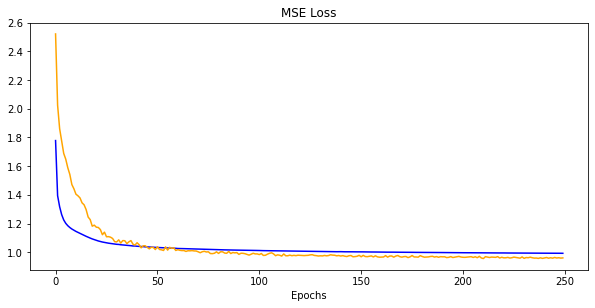

In [ ]:
summarize_diagnostics(history)

In [ ]:
#Loading saved model from disk
LSTM_MLP_reg = models.load_model("/content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_model", custom_objects={'RMSE_error':RMSE_error, 'RMSLE_error':RMSLE_error})

#Loading weights from best model
LSTM_MLP_reg.load_weights("/content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_best.h5")

y_train_pred = LSTM_MLP_reg.predict(X_train_lr[:])
y_cv_pred = LSTM_MLP_reg.predict(X_cv_lr[:])

In [ ]:
#Evaluation
LSTM_MLP_cv_RMSLE = compute_RMSLE(np.array(y_cv_lr), np.array(y_cv_pred))
LSTM_MLP_train_RMSLE = compute_RMSLE(np.array(y_train_lr), np.array(y_train_pred))

LSTM_MLP_cv_RMSE = compute_RMSE(np.array(y_cv_lr), np.array(y_cv_pred))
LSTM_MLP_train_RMSE = compute_RMSE(np.array(y_train_lr), np.array(y_train_pred))

#LSTM_MLP_cv_RMSE_CV = compute_RMSE_CV(y_cv_lr[:], y_cv_pred)
#LSTM_MLP_train_RMSE_CV = compute_RMSE_CV(y_train_lr[:], y_train_pred)

#Report
print("1.For LSTM_MLP Regression Model the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(LSTM_MLP_train_RMSLE, LSTM_MLP_cv_RMSLE))
print("--"*25)
print("2.For LSTM_MLP Regression Model the RMSE values are \n    train RMSE = {0} \n    CV RMSE = {1}".format(LSTM_MLP_train_RMSE, LSTM_MLP_cv_RMSE))
print("--"*25)
#print("2.For LSTM_MLP Regression Model the RMSE(CV) values are \n    train RMSE(CV) = {0} \n    CV RMSE(CV) = {1}".format(LSTM_MLP_train_RMSE_CV, LSTM_MLP_cv_RMSE_CV))
#print("--"*25)



1.For LSTM_MLP Regression Model the RMSLE values are 
    train RMSLE = 0.22 
    CV RMSLE = 0.23
--------------------------------------------------
2.For LSTM_MLP Regression Model the RMSE values are 
    train RMSE = 0.93 
    CV RMSE = 0.95
--------------------------------------------------


### **4.7 Stacking: Mean-Model**
Let's combining predictions of other regression models and compute mean as a final prediction.

In [ ]:
# LightGBM GBDT Model 1
LGBM_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_Rev02.sav')
y_train_pred_LGBM = LGBM_reg_best.predict(X_train)
y_cv_pred_LGBM = LGBM_reg_best.predict(X_cv)

# LightGBM GBDT Model 2
LGBM_reg_best_2 = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_best_Rev02.sav')
y_train_pred_LGBM_2 = LGBM_reg_best_2.predict(X_train)
y_cv_pred_LGBM_2 = LGBM_reg_best_2.predict(X_cv)

# CatBoost Model 01
CatBoost_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/catboost_reg_Rev02.sav')
y_train_pred_CatBoost = CatBoost_reg_best.predict(X_train)
y_cv_pred_CatBoost = CatBoost_reg_best.predict(X_cv)

#CatBoost Model 02
CatBoost_reg_best_2 = joblib.load('/content/drive/MyDrive/Case Study 01/Data/catboost_Model02_Rev02.sav')
y_train_pred_CatBoost_2 = CatBoost_reg_best_2.predict(X_train)
y_cv_pred_CatBoost_2 = CatBoost_reg_best_2.predict(X_cv)

# Decision Tree
DT_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/dt_reg_best_Rev02.sav')
y_train_pred_DT = DT_reg_best.predict(X_train)
y_cv_pred_DT = DT_reg_best.predict(X_cv)

# Random Forest
RF_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/RF_reg_depth15_Rev02.sav')
y_train_pred_RF = RF_reg_best.predict(X_train)
y_cv_pred_RF = RF_reg_best.predict(X_cv)


In [ ]:
#Taking avg of the prediction of above models
y_train_pred_df = pd.DataFrame(list(zip( y_train_pred_LGBM, y_train_pred_LGBM_2, y_train_pred_CatBoost,
                                        y_train_pred_CatBoost_2, y_train_pred_DT, y_train_pred_RF )), 
             columns=[ 'y_tr_LGBM', 'y_tr_LGBM_2', 'y_tr_CatBoost', 'y_tr_CatBoost_2', 'y_train_DT', 'y_train_RF'])

y_cv_pred_df = pd.DataFrame(list(zip(y_cv_pred_LGBM, y_cv_pred_LGBM_2, y_cv_pred_CatBoost,
                                     y_cv_pred_CatBoost_2, y_cv_pred_DT, y_cv_pred_RF)), 
             columns=['y_cv_LGBM', 'y_cv_LGBM_2', 'y_cv_CatBoost', 'y_cv_CatBoost_2', 'y_train-DT', 'y_train-RF'])

y_train_pred_df['y_train_stack'] = y_train_pred_df.mean(axis=1)
y_train_pred = y_train_pred_df.y_train_stack

y_cv_pred_df['y_cv_stack'] = y_cv_pred_df.mean(axis=1)
y_cv_pred = y_cv_pred_df.y_cv_stack

In [ ]:
#Saving Outputs
y_train_pred_df.to_feather('/content/drive/MyDrive/Case Study 01/Data/stack_train_df.ftr')
y_cv_pred_df.to_feather('/content/drive/MyDrive/Case Study 01/Data/stack_cv_df.ftr')

In [ ]:
#Evaluation
Stack_cv_RMSLE = compute_RMSLE(y_cv[:], y_cv_pred)
Stack_train_RMSLE = compute_RMSLE(y_train, y_train_pred)

Stack_cv_RMSE = compute_RMSE(y_cv, y_cv_pred)
Stack_train_RMSE = compute_RMSE(y_train, y_train_pred)

#Report
print("--"*25)
print("1.For Stacking Regression Model the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(Stack_train_RMSLE, Stack_cv_RMSLE))
print("--"*25)
print("2.For Stacking Model the RMSE values are \n    train RMSE = {0} \n    CV RMSE = {1}".format(Stack_train_RMSE, Stack_cv_RMSE))
print("--"*25)


--------------------------------------------------
1.For Stacking Regression Model the RMSLE values are 
    train RMSLE = 0.13 
    CV RMSLE = 0.17
--------------------------------------------------
2.For Stacking Model the RMSE values are 
    train RMSE = 0.48 
    CV RMSE = 0.63
--------------------------------------------------


### **4.8 Custom Stacking Regressor.**

Attaching target variable to training data before splitting

In [ ]:
data = X_train.copy()
data['y'] = y_train
data.head()

,building_id,meter,primary_use,square_feet,floor_info,air_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day_of_Week,day_name,hour,season,RH,Cloud_base,WCI,D/N,y
0,46.0,0.0,11,9045.0,0.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,2.810547
1,830.0,0.0,15,15120.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,2.773438
2,831.0,0.0,1,4065.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.087891
3,832.0,0.0,9,26507.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,4.011719
4,833.0,0.0,9,6392.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.044922


In [ ]:
#Base Model Configuration

DT_reg_1 = DecisionTreeRegressor(max_depth= 27, min_samples_split= 100)
DT_reg_2 = DecisionTreeRegressor(max_depth= 15, min_samples_split= 150)

RF_reg_1 = RandomForestRegressor(n_estimators=250, min_samples_split=50, max_features=0.3, 
                               max_depth=15, n_jobs=50, bootstrap=True, verbose=1)
RF_reg_2 = RandomForestRegressor(n_estimators=250, min_samples_split=50, max_features=0.3, 
                               max_depth=15, n_jobs=50, bootstrap=True, verbose=1)

LGBM_reg_1 = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='rmse', n_estimators=2100)
LGBM_reg_2 = LGBMRegressor(boosting_type='gbdt', num_leaves=20, objective='rmse', n_estimators=2000)


catboost_reg_1 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 2100,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)
catboost_reg_2 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 1500,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)


#Base Model List
base_models = [DT_reg_1, DT_reg_2, RF_reg_1, RF_reg_2, LGBM_reg_1, LGBM_reg_2,  catboost_reg_1, catboost_reg_2]

#Base Model Names
#base_model_names = [str(type(i).__name__) + "_pred"  for i in base_models ]
base_model_names = ["BM_" + str(i)  for i in range(len(base_models)) ]

In [ ]:
#Attaching target variable to training data before splitting
data = X_train.copy()
data['y'] = y_train

#Diving Train data into two dataframes D1 and D2.
D1 = data[:int(len(data)*0.5)]
D2 = data[int(len(data)*0.5):]


#Setting up target variable for D1
y_train_D2 = D2.y
X_train_D2 = D2.drop(['y'], axis=1)

In [ ]:
def cust_ensemble(D1, D2 , base_models, sample_frac = 0.6):
  
  base_model_names = ["BM_" + str(i)  for i in range(len(base_models))]

  #Setting up target variable for D2
  y_train_D2 = D2.y
  X_train_D2 = D2.drop(['y'], axis=1)

  prediction_df = pd.DataFrame()

  #Training Base Learners on D1 
  for i in tqdm(range(len(base_models))):

    #Generating Sample from D1
    sample = D1.sample(n=None, frac= sample_frac, replace=True).reset_index(drop=True)

    #Setting up target variable for D1
    y_train_D1 = sample.y
    X_train_D1 = sample.drop(['y'], axis=1)

    #Training Base Models on D1
    base_models[i].fit(X_train_D1, y_train_D1)

    #Predicting D2
    base_model_pred = base_models[i].predict(X_train_D2)

    #Attaching basemodel predictions to dataframe
    prediction_df[base_model_names[i]] = base_model_pred

  base_models_trained = base_models

  return base_models_trained, prediction_df

In [ ]:
if not os.path.isfile("/content/drive/MyDrive/Case Study 01/Data/base_models.pckl"):
  base_models_trained, D2_pred_df = cust_ensemble(D1, D2, base_models, sample_frac = 0.6)

  #Saving Trained models into disk.
  with open("/content/drive/MyDrive/Case Study 01/Data/base_models.pckl", "wb") as file:
    pickle.dump(base_models_trained, file)

 25%|██▌       | 2/8 [01:59<05:52, 58.68s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:  9.3min
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed: 22.6min finished
[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   39.2s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:  1.5min finished
 38%|███▊      | 3/8 [26:06<57:41, 692.38s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed: 10.3min
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed: 24.1min finished
[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   37.6s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:  1.4min finished
100%|██████████| 8/8 [1:13:50<00:00, 553.80s/it]


In [ ]:
def test_pred(test_data, base_models_trained):
  test_pred_df = pd.DataFrame()
  for i in tqdm(range(len(base_models_trained))):
    test_pred = base_models_trained[i].predict(test_data)
    test_pred_df["BM_" + str(i)] = test_pred
  return test_pred_df

In [ ]:
with open("/content/drive/MyDrive/Case Study 01/Data/base_models.pckl" , 'rb') as f:
    base_models_trained = pickle.load(f)

CV_pred_df = test_pred(X_cv, base_models_trained)


 25%|██▌       | 2/8 [00:02<00:06,  1.11s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   20.5s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:   46.6s finished
 38%|███▊      | 3/8 [00:49<01:50, 22.01s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   19.9s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:   46.1s finished
100%|██████████| 8/8 [06:55<00:00, 51.88s/it]


In [ ]:
CV_pred_df.head()

,BM_0,BM_1,BM_2,BM_3,BM_4,BM_5,BM_6,BM_7
0,4.421404,4.395725,4.589173,4.512558,4.649163,4.684261,4.513004,4.673037
1,4.598166,4.395725,4.516213,4.495396,4.380764,4.602960,4.558722,4.755367
2,3.878548,3.960264,3.795249,3.878863,3.453527,3.372506,3.300869,3.478809
3,4.434559,4.775727,4.395662,4.404587,4.586109,4.416220,4.471923,4.559396
4,4.575396,3.653439,3.895208,3.881914,4.095831,4.060068,3.910902,4.065018


In [ ]:
# Config Meta Regressor LightGBM
if not os.path.isfile("/content/drive/MyDrive/Case Study 01/Data/meta_reg.pckl"):
  meta_reg = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='rmse', n_estimators=2100)
  meta_reg.fit(D2_pred_df, y_train_D2)
  with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg.pckl", "wb") as file:
    pickle.dump(meta_reg, file)
else:
  with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg.pckl" , 'rb') as file:
    meta_reg = pickle.load(file)

In [ ]:
#Predicting test 
y_CV_pred = meta_reg.predict(CV_pred_df)

In [ ]:
#Computing RMSE
compute_RMSE(y_cv ,y_CV_pred)

0.64

### **4.9 Custom Stacking Regressor.**

Attaching target variable to training data before splitting

In [ ]:
data = X_train.copy()
data['y'] = y_train
data.head()

,building_id,meter,primary_use,square_feet,floor_info,air_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day_of_Week,day_name,hour,season,RH,Cloud_base,WCI,D/N,y
0,46.0,0.0,11,9045.0,0.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,2.810547
1,830.0,0.0,15,15120.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,2.773438
2,831.0,0.0,1,4065.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.087891
3,832.0,0.0,9,26507.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,4.011719
4,833.0,0.0,9,6392.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.044922


In [ ]:
data['square_feet'] = np.log1p(data.square_feet)

In [ ]:
#Base Model Configuration
LGBM_reg_1 = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='regression', leaves = 40,
                           n_estimators=1000, n_jobs=50, reg_lambda=0.01, feature_fraction = 0.85,
                           learning_rate=0.05)
LGBM_reg_2 = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='regression', leaves = 60,
                           n_estimators=1500, n_jobs=50, reg_lambda=0.1, feature_fraction = 1,
                           learning_rate=0.01)
LGBM_reg_3 = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='regression', leaves = 80,
                           n_estimators=1800, n_jobs=50, reg_lambda=2, feature_fraction = 0.85,
                           learning_rate=0.01)
LGBM_reg_4 = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='regression', leaves = 150,
                           n_estimators=2100, n_jobs=50, reg_lambda=8, feature_fraction = 1,
                           learning_rate=0.01)
LGBM_reg_5 = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='regression', leaves = 500,
                           n_estimators=2500, n_jobs=50, reg_lambda=10, feature_fraction = 0.85,
                           learning_rate=0.01)


catboost_reg_1 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 2100,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)
catboost_reg_2 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 1500,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)
catboost_reg_3 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 1300,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)
catboost_reg_4 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 1200,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)
catboost_reg_5 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 1000,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)


#Base Model List
base_models = [LGBM_reg_1, LGBM_reg_2, LGBM_reg_3, LGBM_reg_4, LGBM_reg_5, 
               catboost_reg_1, catboost_reg_2, catboost_reg_3, catboost_reg_4, catboost_reg_5]

#Base Model Names
#base_model_names = [str(type(i).__name__) + "_pred"  for i in base_models ]
base_model_names = ["BM_" + str(i)  for i in range(len(base_models)) ]

In [ ]:
#Attaching target variable to training data before splitting
data = X_train.copy()
data['y'] = y_train

#Diving Train data into two dataframes D1 and D2.
D1 = data[:int(len(data)*0.5)]
D2 = data[int(len(data)*0.5):]


#Setting up target variable for D1
y_train_D2 = D2.y
X_train_D2 = D2.drop(['y'], axis=1)

In [ ]:
def cust_ensemble(D1, D2 , base_models, sample_frac = 0.6):
  
  base_model_names = ["BM_" + str(i)  for i in range(len(base_models))]

  #Setting up target variable for D2
  y_train_D2 = D2.y
  X_train_D2 = D2.drop(['y'], axis=1)

  prediction_df = pd.DataFrame()

  #Training Base Learners on D1 
  for i in tqdm(range(len(base_models))):

    #Generating Sample from D1
    sample = D1.sample(n=None, frac= sample_frac, replace=True).reset_index(drop=True)

    #Setting up target variable for D1
    y_train_D1 = sample.y
    X_train_D1 = sample.drop(['y'], axis=1)

    #Training Base Models on D1
    base_models[i].fit(X_train_D1, y_train_D1)

    #Predicting D2
    base_model_pred = base_models[i].predict(X_train_D2)

    #Attaching basemodel predictions to dataframe
    prediction_df[base_model_names[i]] = base_model_pred

  base_models_trained = base_models

  return base_models_trained, prediction_df

In [ ]:
base_models_trained, D2_pred_df = cust_ensemble(D1, D2, base_models, sample_frac = 0.7)

#Saving Trained models into disk.
with open("/content/drive/MyDrive/Case Study 01/Data/base_models_Rev02b.pckl", "wb") as file:
  pickle.dump(base_models_trained, file)

100%|██████████| 10/10 [1:22:02<00:00, 492.26s/it]


In [ ]:
if not os.path.isfile("/content/drive/MyDrive/Case Study 01/Data/base_models_Rev02b.pckl"):
  base_models_trained, D2_pred_df = cust_ensemble(D1, D2, base_models, sample_frac = 0.7)

  #Saving Trained models into disk.
  with open("/content/drive/MyDrive/Case Study 01/Data/base_models_Rev02b.pckl", "wb") as file:
    pickle.dump(base_models_trained, file)

In [ ]:
def test_pred(test_data, base_models_trained):
  test_pred_df = pd.DataFrame()
  for i in tqdm(range(len(base_models_trained))):
    test_pred = base_models_trained[i].predict(test_data)
    test_pred_df["BM_" + str(i)] = test_pred
  return test_pred_df

In [ ]:
with open("/content/drive/MyDrive/Case Study 01/Data/base_models_Rev02b.pckl" , 'rb') as f:
    base_models_trained = pickle.load(f)

CV_pred_df = test_pred(X_cv, base_models_trained)


100%|██████████| 10/10 [13:44<00:00, 82.44s/it]


In [ ]:
CV_pred_df.head()

,BM_0,BM_1,BM_2,BM_3,BM_4,BM_5,BM_6,BM_7,BM_8,BM_9
0,4.452112,4.428900,4.539385,4.483145,4.484542,4.368367,4.495602,4.373081,4.618345,4.460286
1,4.483855,4.401315,4.436537,4.479903,4.434703,4.701753,4.644870,4.654875,4.676072,4.684875
2,3.836917,3.752333,3.964703,3.792983,3.989542,3.461438,3.379353,3.450435,3.501292,3.466613
3,4.280728,3.962946,4.138187,4.086804,4.146983,4.489341,4.429124,4.326776,4.438140,4.473698
4,3.894228,3.746428,3.941727,3.785135,3.902116,4.047766,4.118484,3.964527,3.879841,3.900283


In [ ]:
# Config Meta Regressor LightGBM
if not os.path.isfile("/content/drive/MyDrive/Case Study 01/Data/meta_reg_Rev02.pckl"):
  meta_reg = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='regression', n_estimators=2100)
  meta_reg.fit(D2_pred_df, y_train_D2)
  with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg_Rev02.pckl", "wb") as file:
    pickle.dump(meta_reg, file)
else:
  with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg_Rev02.pckl" , 'rb') as file:
    meta_reg = pickle.load(file)

In [ ]:
meta_reg = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='regression', n_estimators=2100)
meta_reg.fit(D2_pred_df, y_train_D2)

LGBMRegressor(n_estimators=2100, objective='regression')

In [ ]:
#Predicting test 
y_CV_pred = meta_reg.predict(CV_pred_df)

In [ ]:
#Computing RMSE
compute_RMSE(y_cv ,y_CV_pred)

0.68

# **5. Summary:** <br>
**Representation of Results:**

In [ ]:
from prettytable import PrettyTable
results = PrettyTable()
results.field_names = ["Sr. No.","Model","Best Params", "RMSLE(Train)","RMSLE(CV)", "RMSE(Train)", "RMSE(CV)"]
results.add_row(["1.","Baseline \n", "Linear Regression" , "0.32", "0.34", "1.44", "1.48" ])
results.add_row(["2.","Decision Trees \n(trained on 2000000 samples)\n", "max_depth=27, min_samples_split=100", "0.08" , "0.17", "0.32", "0.68" ])
results.add_row(["3.","Random Forest\n","min_samples_split:50, n_estimators:250 \n Max_depth:15", "0.17", "0.20", "0.65", "0.76" ])
results.add_row(["4.","\nLightGBM\n","\nboosting=gbdt, 'min_child_samples': 31, \n'n_est.=2100", "\n0.12", "\n0.16", "\n0.45","\n0.63"])
results.add_row(["5.","\nCatBoost\n ","\nboosting=gbdt, 'n_est.=2100", "\n0.16", "\n0.18", "\n0.61","\n0.69"])
results.add_row(["6.","\nMLP\n","\nloss=mse, Adam, Epoch=300  ", "\n0.14", "\n0.18", "\n0.56", "\n0.71"])
results.add_row(["7.","\nLSTM\n","\nloss=mse, Adam, Epoch=250  ", "\n0.22", "\n0.23", "\n0.93", "\n0.95"])
results.add_row(["8.","\nStacking\n","\nLGM + DT + RF +CB ", "\n0.13", "\n0.17", "\n0.48", "\n0.63"])
print(results)

+---------+------------------------------+------------------------------------------+--------------+-----------+-------------+----------+
| Sr. No. |            Model             |               Best Params                | RMSLE(Train) | RMSLE(CV) | RMSE(Train) | RMSE(CV) |
+---------+------------------------------+------------------------------------------+--------------+-----------+-------------+----------+
|    1.   |          Baseline            |            Linear Regression             |     0.32     |    0.34   |     1.44    |   1.48   |
|         |                              |                                          |              |           |             |          |
|    2.   |       Decision Trees         |   max_depth=27, min_samples_split=100    |     0.08     |    0.17   |     0.32    |   0.68   |
|         | (trained on 2000000 samples) |                                          |              |           |             |          |
|         |                       

# **6. Loading Test Data:**

Preparing Test Data to make it compatible with trained models:

##### **6.4.1 Test Data - unscaled.**

In [ ]:
#Loading data from the disk
test_data = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/test_data_processed.ftr")
site_id_info_test = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.ftr")
meter_type_info_test = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.ftr")

#Dropping Unwanted Features
test_data = test_data.drop(['site_id', 'dew_temperature', 'year', 'Ea', 'Es'], axis=1)


##### **6.4.2 Test Data- Scaled**

In [ ]:
#Loading data from the disk
test_data_scaled = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/test_data_processed_scaled.ftr")
site_id_info_test = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.ftr")
meter_type_info_test = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.ftr")

#Dropping Unwanted Features
test_data_scaled = test_data_scaled.drop(['site_id', 'dew_temperature', 'year', 'Ea', 'Es'], axis=1)

#### **6.5 Target Inverse Transformation**

* As we have used log transformation on the target variable, Need to inverse it using Exponential Function.
* For site_0 meter readings, we have converted the origional unites from to kBTU to KW. So before submission, need to convert back in their origional form i.e. in kBTU, i.e. to multiply by 3.4118. 

In [ ]:
def target_transf(site_id_info: "site_ids from the given data ",
                  meter_type_info:"meter types of each datapoint",
                  predicted_op: "predicted outputs from the model") -> "Returns Transfoemed Output":
  '''
  1.As we have used log transformation on the target variable, Need to inverse it using Exponential Function.
  2.For site_0 Electrical Meter readings, we have converted the origional unites from to kBTU to KW. So before submission,
  need to convert back in their origional form i.e. in kBTU, i.e. to multiply by 3.4118.
  '''

  # Target Transformation
  pred_df = site_id_info_test.copy()
  pred_df['meter'] = meter_type_info_test
  pred_df['test_pred'] = np.expm1(predicted_op)

  # Unit Conversion for site_0
  pred_df['test_pred']= np.where(np.logical_and(pred_df['site_id'] == 0, pred_df['meter'] == 0),
                                  pred_df['test_pred'] * 3.4118,
                                  pred_df['test_pred'])

  # Dropping site_id feature
  pred_df = pred_df.drop(['site_id', 'meter'], axis=1)
    
  # Adding row_id features are shown in sample_submission file
  pred_df = pred_df.reset_index()
  pred_df.columns = ['row_id', 'meter_reading']

  return pred_df

# **7. Target Predictions:**

#### **7.1 Base Model**

In [ ]:
# load the model from disk
Base_model = joblib.load('/content/drive/MyDrive/Case Study 01/Data/base_model_Rev02.sav')

#Predicting Test Data
test_pred = Base_model.predict(test_data_scaled)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/Base_model_test_predictions_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,85.594397
1,1,82.763013
2,2,84.379832
3,3,96.248339
4,4,186.050239
...,...,...
41697595,41697595,63.575974
41697596,41697596,57.234970
41697597,41697597,59.981728
41697598,41697598,67.814751


### **7.2 Decision Tree Regressor:**

In [ ]:
# load the model from disk
DT_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/dt_reg_best_Rev02.sav')

#Predicting Test Data
test_pred = DT_reg_best.predict(test_data)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/DT_test_predictions_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,47.588415
1,1,17.315888
2,2,4.302626
3,3,506.677322
4,4,85.832775
...,...,...
41697595,41697595,7.207627
41697596,41697596,5.477344
41697597,41697597,9.969417
41697598,41697598,175.087696


### **7.3 Random Forest**

In [ ]:
# load the model from disk
RF_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data//RF_reg_depth15_Rev02.sav')

#Predicting Test Data
test_pred = RF_reg_best.predict(test_data)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/RF_test_predictions_Rev02.csv', index = False)

### **7.4 LGB Regressor**

##### **7.4.1 Model 1:**

In [ ]:
# load the model from disk
LGBM_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_Rev02.sav')

#Predicting Test Data
test_pred = LGBM_reg_best.predict(test_data)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/LGBM_Model1_pred_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,66.762195
1,1,17.998364
2,2,1.230692
3,3,114.943310
4,4,104.784334
...,...,...
41697595,41697595,5.712131
41697596,41697596,4.580241
41697597,41697597,6.560214
41697598,41697598,164.992018


##### **7.4.2 Model 2: With Best Model:**  

In [ ]:
# load the model from disk
LGBM_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_best_Rev02.sav')

#Predicting Test Data
test_pred = LGBM_reg_best.predict(test_data)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/LGBM_Best_predictions_Rev02.csv', index = False)

In [ ]:
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/LGBM_Best_predictions_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,36.417987
1,1,11.397480
2,2,0.648718
3,3,61.398948
4,4,229.670441
...,...,...
41697595,41697595,5.889718
41697596,41697596,3.792710
41697597,41697597,5.539892
41697598,41697598,163.537119


### **7.5 Catboost Regressor**

##### **7.5.1 Model 1:**

In [ ]:
# load the model from disk
catboost_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/catboost_reg_Rev02.sav')

#Predicting Test Data
test_pred = catboost_reg_best.predict(test_data)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/catboost_Model1_pred_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,36.401948
1,1,16.369875
2,2,2.990715
3,3,128.592594
4,4,357.549339
...,...,...
41697595,41697595,5.991785
41697596,41697596,4.900376
41697597,41697597,5.666152
41697598,41697598,156.571478


##### **7.5.2 Model 2:**

In [ ]:
# load the model from disk
catboost_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/catboost_Model02_Rev02.sav')

#Predicting Test Data
test_pred = catboost_reg_best.predict(test_data)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/catboost_Model2_pred_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,42.662581
1,1,15.690704
2,2,7.666489
3,3,157.936348
4,4,525.704051
...,...,...
41697595,41697595,6.145453
41697596,41697596,4.377842
41697597,41697597,5.531190
41697598,41697598,132.073055


### **7.6 MLP Regerssion:**

##### **7.6.1 Model 1: MLP**

In [ ]:
#Loading saved model from disk
MLP_reg = models.load_model("/content/drive/MyDrive/Case Study 01/MLP Output//MLP_reg_normal_Rev02", custom_objects={'RMSE_error':RMSE_error, 'RMSLE_error':RMSLE_error})

#Loading weights from best model
MLP_reg.load_weights("/content/drive/MyDrive/Case Study 01/MLP Output/MLP_model01.h5")


#Predicting Test Data
test_pred = MLP_reg.predict(test_data_scaled)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/MLP_test_predictions_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,39.467510
1,1,28.808020
2,2,29.740059
3,3,65.213446
4,4,97.704553
...,...,...
41697595,41697595,7.537397
41697596,41697596,5.795458
41697597,41697597,6.678843
41697598,41697598,41.216263


##### **7.6.2 Model 2: LSTM MLP**

In [ ]:
#Loading saved model from disk
LSTM_MLP_reg = models.load_model("/content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_model", custom_objects={'RMSE_error':RMSE_error, 'RMSLE_error':RMSLE_error})

#Loading weights from best model
LSTM_MLP_reg.load_weights("/content/drive/MyDrive/Case Study 01/MLP Output/LSTM_MLP_best.h5")


#Predicting Test Data
test_pred = LSTM_MLP_reg.predict(test_data_scaled)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/LSTM_test_predictions_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,60.013367
1,1,23.319902
2,2,34.759987
3,3,154.458526
4,4,469.002762
...,...,...
41697595,41697595,14.877569
41697596,41697596,6.396008
41697597,41697597,6.350242
41697598,41697598,61.509216


### **7.7 Stacking**

In [ ]:
#Loading outputs from other models

LGBM_test_predictions_1 = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/LGBM_Model1_pred_Rev02.csv')
LGBM_test_predictions_2 = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/LGBM_Best_predictions_Rev02.csv')

CatBoost_test_predictions_1 = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/catboost_Model1_pred_Rev02.csv')
CatBoost_test_predictions_2 = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/catboost_Model2_pred_Rev02.csv')

DT_test_predictions = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/DT_test_predictions_Rev02.csv')
RF_test_predictions = pd.read_csv('/content/drive/MyDrive/Case Study 01/Data/RF_test_predictions_Rev02.csv')

#Creating Dataframe
y_test_pred_df = pd.DataFrame(list(zip(LGBM_test_predictions_1.meter_reading, LGBM_test_predictions_2.meter_reading,
                                       CatBoost_test_predictions_1.meter_reading, CatBoost_test_predictions_2.meter_reading,
                                       DT_test_predictions.meter_reading, RF_test_predictions.meter_reading)), 
                                       columns=[ 'y_LGBM_1', 'y_LGBM_2', 'y_CB_1', 'y_CB_2', 'y_DT', 'y_RF'])

#Computing average meter reading from predictions
y_test_pred_df['y_test_stack'] = y_test_pred_df.mean(axis=1)
y_test_stack = pd.DataFrame(y_test_pred_df.y_test_stack)

#Adding new feature - 'row_id'
y_test_stack = y_test_stack.reset_index()
y_test_stack.columns = ['row_id', 'meter_reading']

#Saving predictions in disk
y_test_stack.to_csv('/content/drive/MyDrive/Case Study 01/Data/Stacking_test_predictions_Rev02.csv', index = False)

In [ ]:
y_test_stack

,row_id,meter_reading
0,0,48.308323
1,1,18.145976
2,2,8.974774
3,3,177.003058
4,4,144.545055
...,...,...
41697595,41697595,6.947135
41697596,41697596,5.373602
41697597,41697597,7.445911
41697598,41697598,148.385954


### **7.8 Custom Regressor**

In [ ]:
#Loading trained base_learners from the disk.
with open("/content/drive/MyDrive/Case Study 01/Data/base_models.pckl" , 'rb') as f:
    base_models_trained = pickle.load(f)

test_df = test_pred(test_data, base_models_trained)

 25%|██▌       | 2/8 [00:22<01:04, 10.74s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   24.8s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:   50.2s finished
 38%|███▊      | 3/8 [01:16<02:30, 30.11s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   22.9s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:   47.6s finished
100%|██████████| 8/8 [16:35<00:00, 124.39s/it]


In [ ]:
#Storig baselearner outputs
test_df.to_feather("/content/drive/MyDrive/Case Study 01/Data/baselearner_op_test_df_Rev01.ftr")

In [ ]:
test_df.head()

,BM_0,BM_1,BM_2,BM_3,BM_4,BM_5,BM_6,BM_7
0,3.542256,3.613530,2.464417,2.516501,2.972076,2.996624,3.303654,3.234284
1,2.157096,3.297233,1.981345,1.950636,1.630631,1.741888,2.456361,2.268881
2,0.363932,1.943706,1.945412,2.043647,0.973257,1.109406,1.734632,1.979340
3,3.641257,5.011304,3.351634,3.418360,3.354226,3.081380,4.136438,4.291514
4,3.543174,3.370257,4.284699,4.412818,3.681417,3.789504,4.432597,5.057011


In [ ]:
#Loading outputs of base learners
test_df = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/baselearner_op_test_df.ftr")

#Loading meta_regresser model from the disk
with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg.pckl" , 'rb') as file:
  meta_reg = pickle.load(file)

#Predicting Test Data
test_pred = meta_reg.predict(test_df)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/custom_reg_prediction.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,93.517592
1,1,8.585437
2,2,5.774674
3,3,32.773975
4,4,96.949003
...,...,...
41697595,41697595,6.627540
41697596,41697596,4.380962
41697597,41697597,9.183973
41697598,41697598,172.022688


### **7.9 Custom Regressor**

In [ ]:
#Loading trained base_learners from the disk.
with open("/content/drive/MyDrive/Case Study 01/Data/base_models_Rev02b.pckl" , 'rb') as f:
    base_models_trained = pickle.load(f)

test_df = test_pred(test_data, base_models_trained)

100%|██████████| 10/10 [2:12:02<00:00, 792.29s/it]


In [ ]:
#Storig baselearner outputs
test_df.to_feather("/content/drive/MyDrive/Case Study 01/Data/baselearner_op_test_df_Rev02.ftr")

In [ ]:
test_df.head()

,BM_0,BM_1,BM_2,BM_3,BM_4,BM_5,BM_6,BM_7,BM_8,BM_9
0,2.829619,2.928431,3.054557,3.195661,3.010272,2.768412,2.345564,2.626149,2.792737,3.189853
1,1.790412,1.284506,1.482207,1.558794,1.752818,2.275566,2.268717,2.303551,1.969577,2.021859
2,1.334717,1.953796,2.057871,2.057718,1.492493,1.808386,1.742917,1.826466,1.661085,1.742554
3,3.238555,3.854506,3.668053,3.767655,3.622490,3.771842,4.306426,3.750273,4.169184,4.125807
4,4.009966,5.414796,5.398893,5.140188,4.922506,4.474683,4.653741,4.821378,4.721032,4.821278


In [ ]:
#Loading outputs of base learners
test_df = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/baselearner_op_test_df_Rev02.ftr")

#Loading meta_regresser model from the disk
with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg_Rev02.pckl" , 'rb') as file:
  meta_reg = pickle.load(file)

#Predicting Test Data
test_pred = meta_reg.predict(test_df)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/custom_reg_prediction_Rev02.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,33.279090
1,1,13.180715
2,2,4.085724
3,3,91.557403
4,4,47.063574
...,...,...
41697595,41697595,7.002379
41697596,41697596,3.950683
41697597,41697597,5.809380
41697598,41697598,245.359243


# **8. Submitting Predictions**

**Kaggle Leaderboard Scoring:**

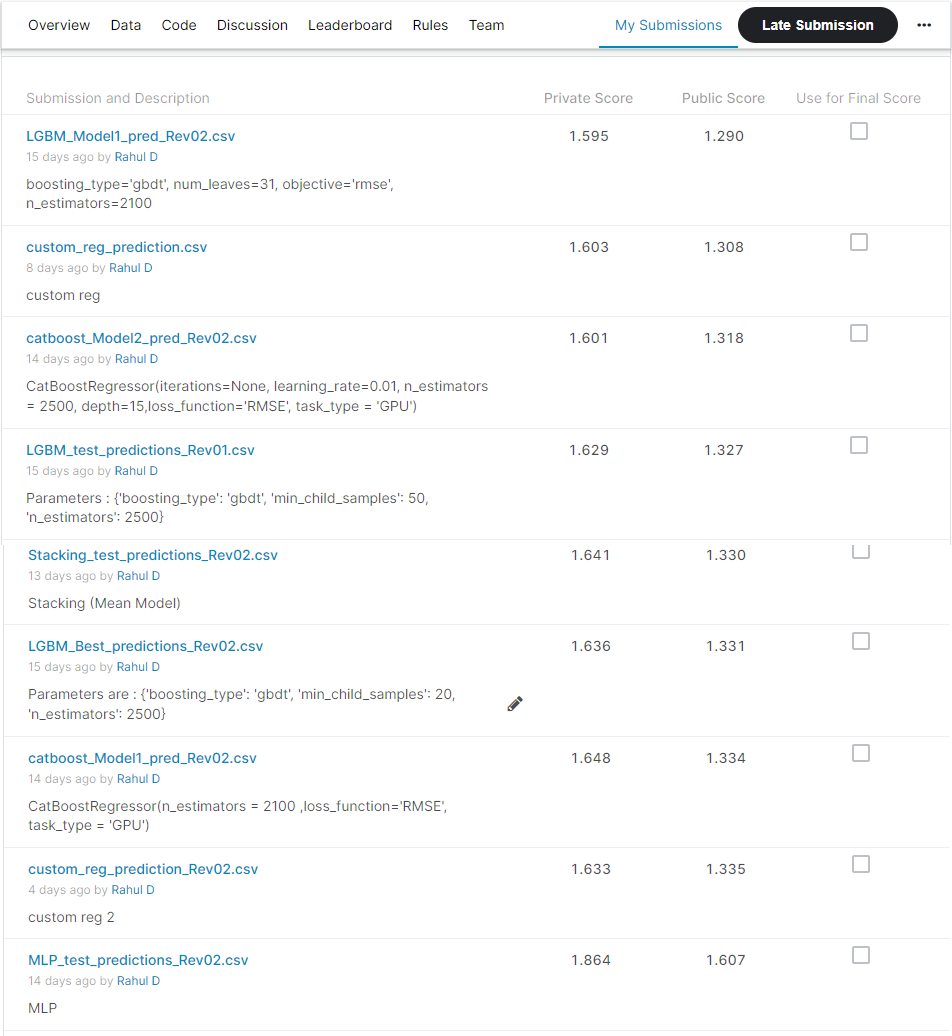

With LightGBM - GBDT model, I got **public score = 1.290** and **private score = 1.595.**

# **8.Future Work:**

* As the dataset is huge, hyperparameter tuning and training the models such as SVR is not possible with the limited computational resources I have. Another idea is to train seperate model for each site. I would like to try this whenever I have enough resources available.
* Many kaggle participants had used data leaks, which are avaible publicly,to improve the score further. I would like to try this as well with the models which I have trained, to see if the score can be improved further.

`CONTD PART C: Post Training Analysis..`